# MNIST: Log-Linear Model v.s. Autoencoder

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.neighbors import KernelDensity

from tqdm import tqdm

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from PIL import Image

from joblib import Parallel, delayed

from utlis import renormalize_image, vectorize_tensor, reconstruct_tensor
import ld

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Setup

### General

In [2]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    cp.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(2)
k = 8
bandwidth = 0.05
bandwidth_AE = 0.05
eps = np.asarray(1.0e-5)
plot_num = 20
paper_plot_num = 1

### Dataset

In [3]:
D = 28*28
S = (7, 2, 2, 7, 2, 2)
train_size = 100
num_new_samples = 20

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)

save_dir = './data/MNIST_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    # Save images by class
    for class_label in range(10):
        class_dir = os.path.join(save_dir, str(class_label))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        basis = np.where(train_dataset.targets.numpy() == class_label)[0]
        for i, idx in enumerate(basis):
            img, _ = train_dataset[idx]
            img = transforms.ToPILImage()(img)
            img.save(os.path.join(class_dir, f'{i}.png'))

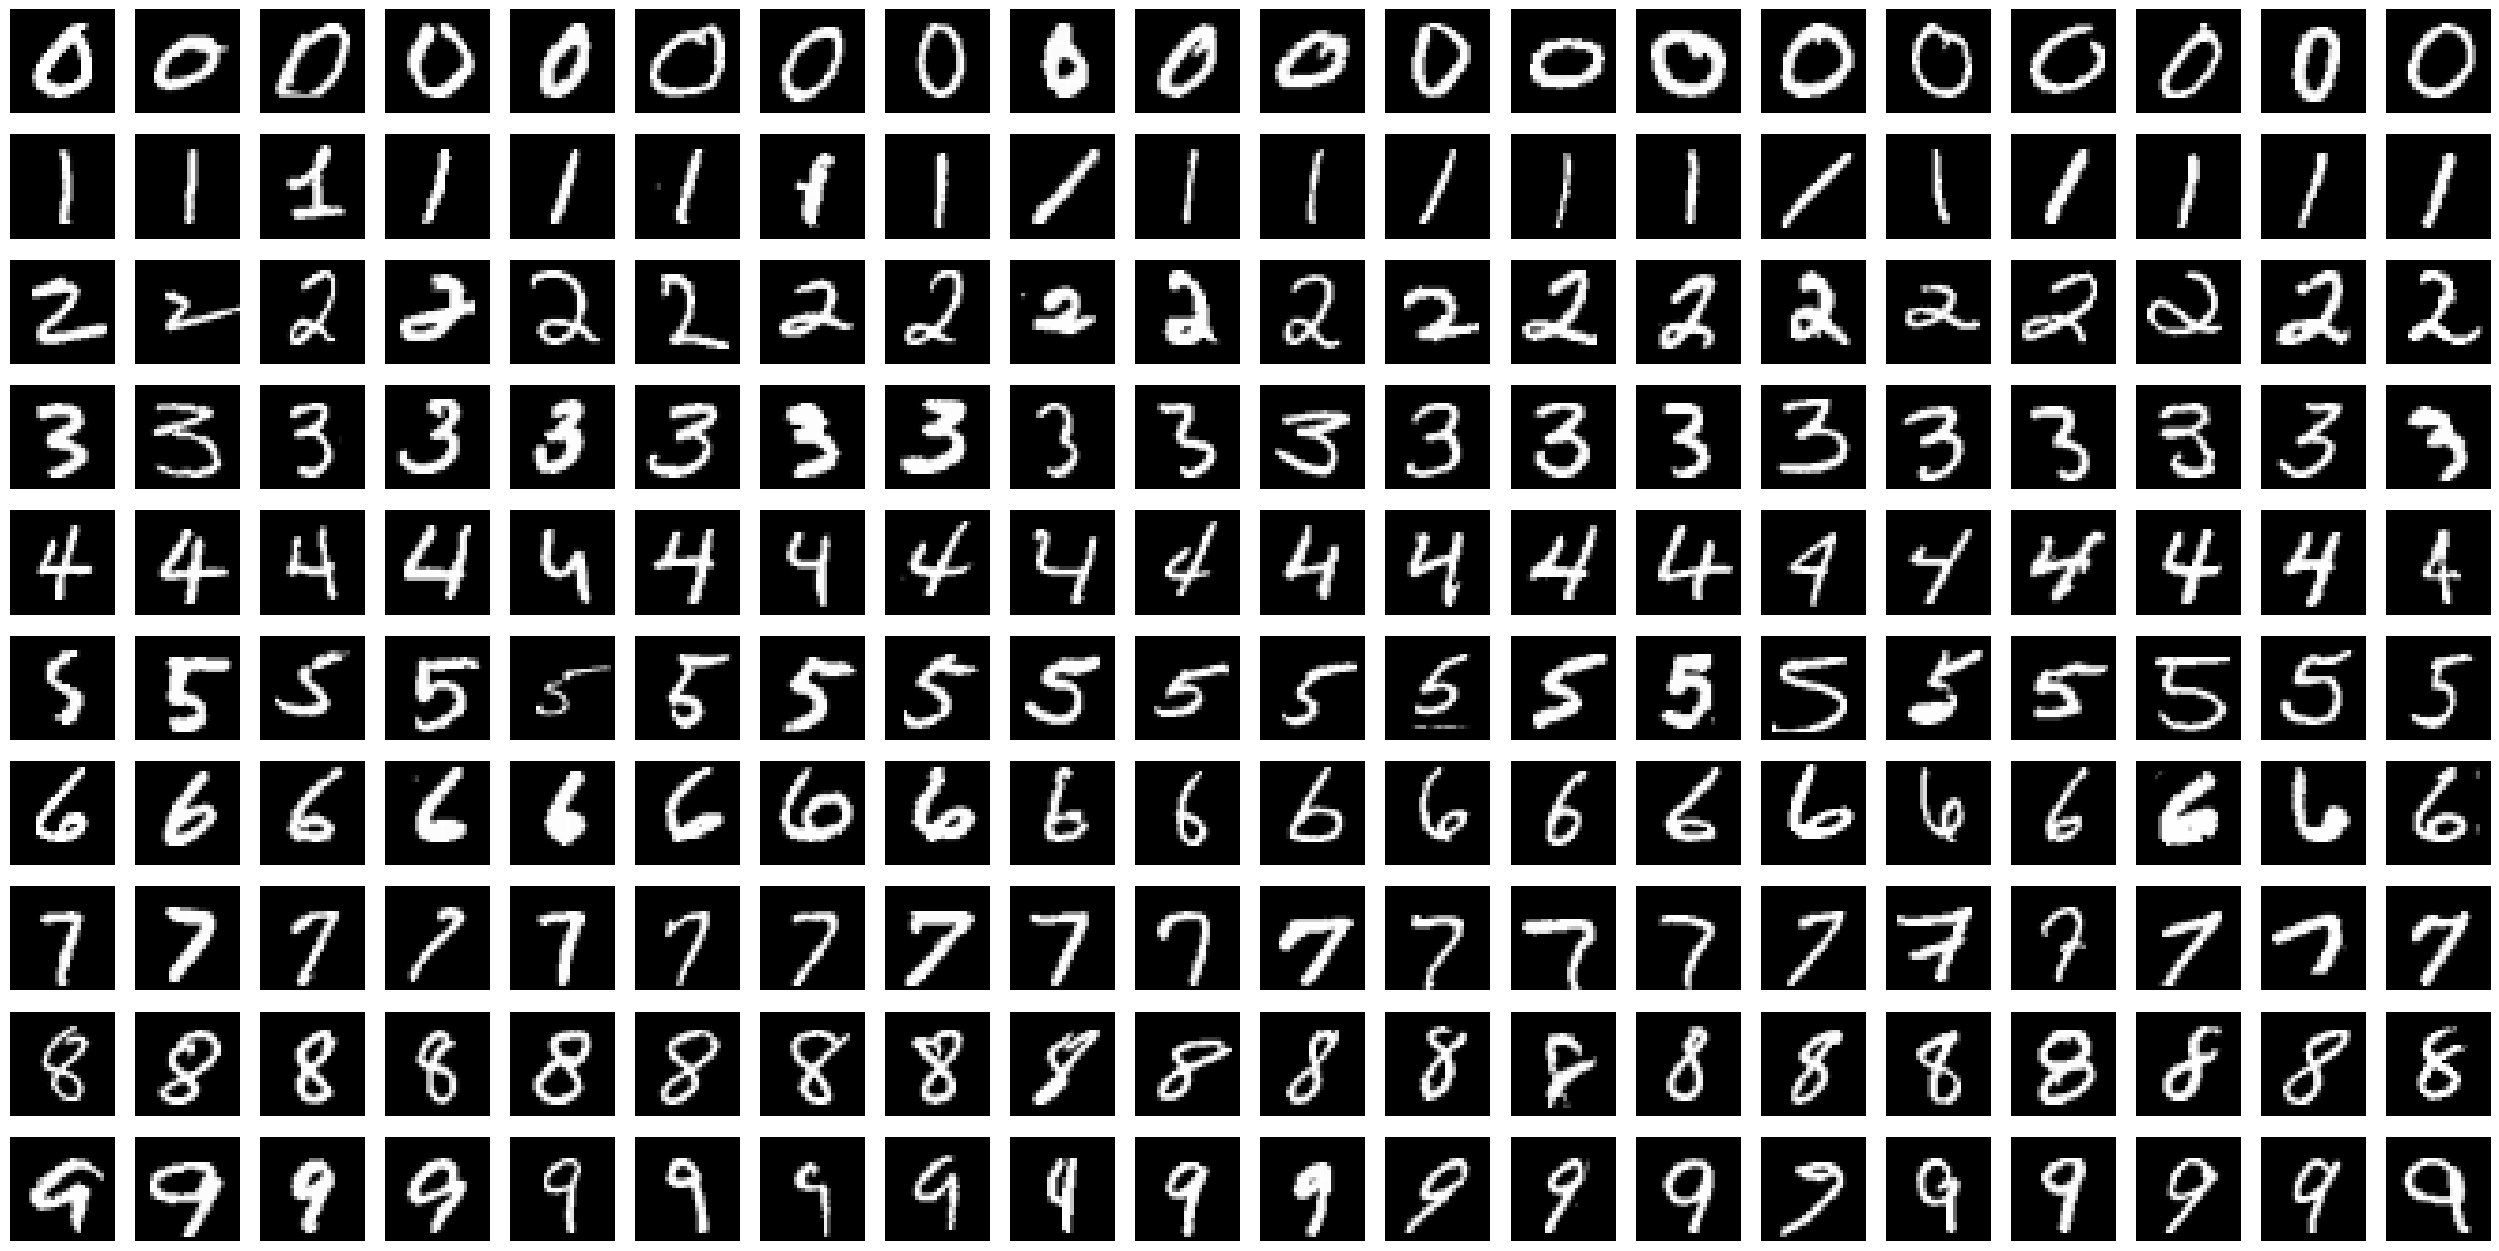

In [5]:
# Function to load images from a directory
def load_images_from_folder(folder, max_images=20):
    images = []
    for filename in os.listdir(folder)[:max_images]:
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

P_digit = []
original_data = []

for digit in range(10):
    class_folder = os.path.join(save_dir, str(digit))
    images = load_images_from_folder(class_folder, max_images=train_size)

    P = []
    for i in range(len(images)):
        img = images[i]
        img = img.resize((28, 28))
        original_data.append(np.asarray(img))
        array_obj = np.asarray(img).reshape(S)
        P.append(array_obj)

    P_digit.append(np.array(P))

# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][i].reshape((28,28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

### Build Dataloader for Later

In [6]:
# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy array): NumPy array of shape (num, 28*28)
            labels (numpy array): Corresponding labels for each image
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image and label for a given index
        image = self.data[idx].reshape(28, 28).astype(np.float32) / 255.0 # Reshape from 28*28 to 28x28
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_data_original = np.array(original_data)
labels = np.repeat(np.arange(10), train_size)
custom_train_dataset = CustomDataset(train_data_original, labels, transform=transforms.ToTensor())
train_loader_original = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)

## Direct Fitting

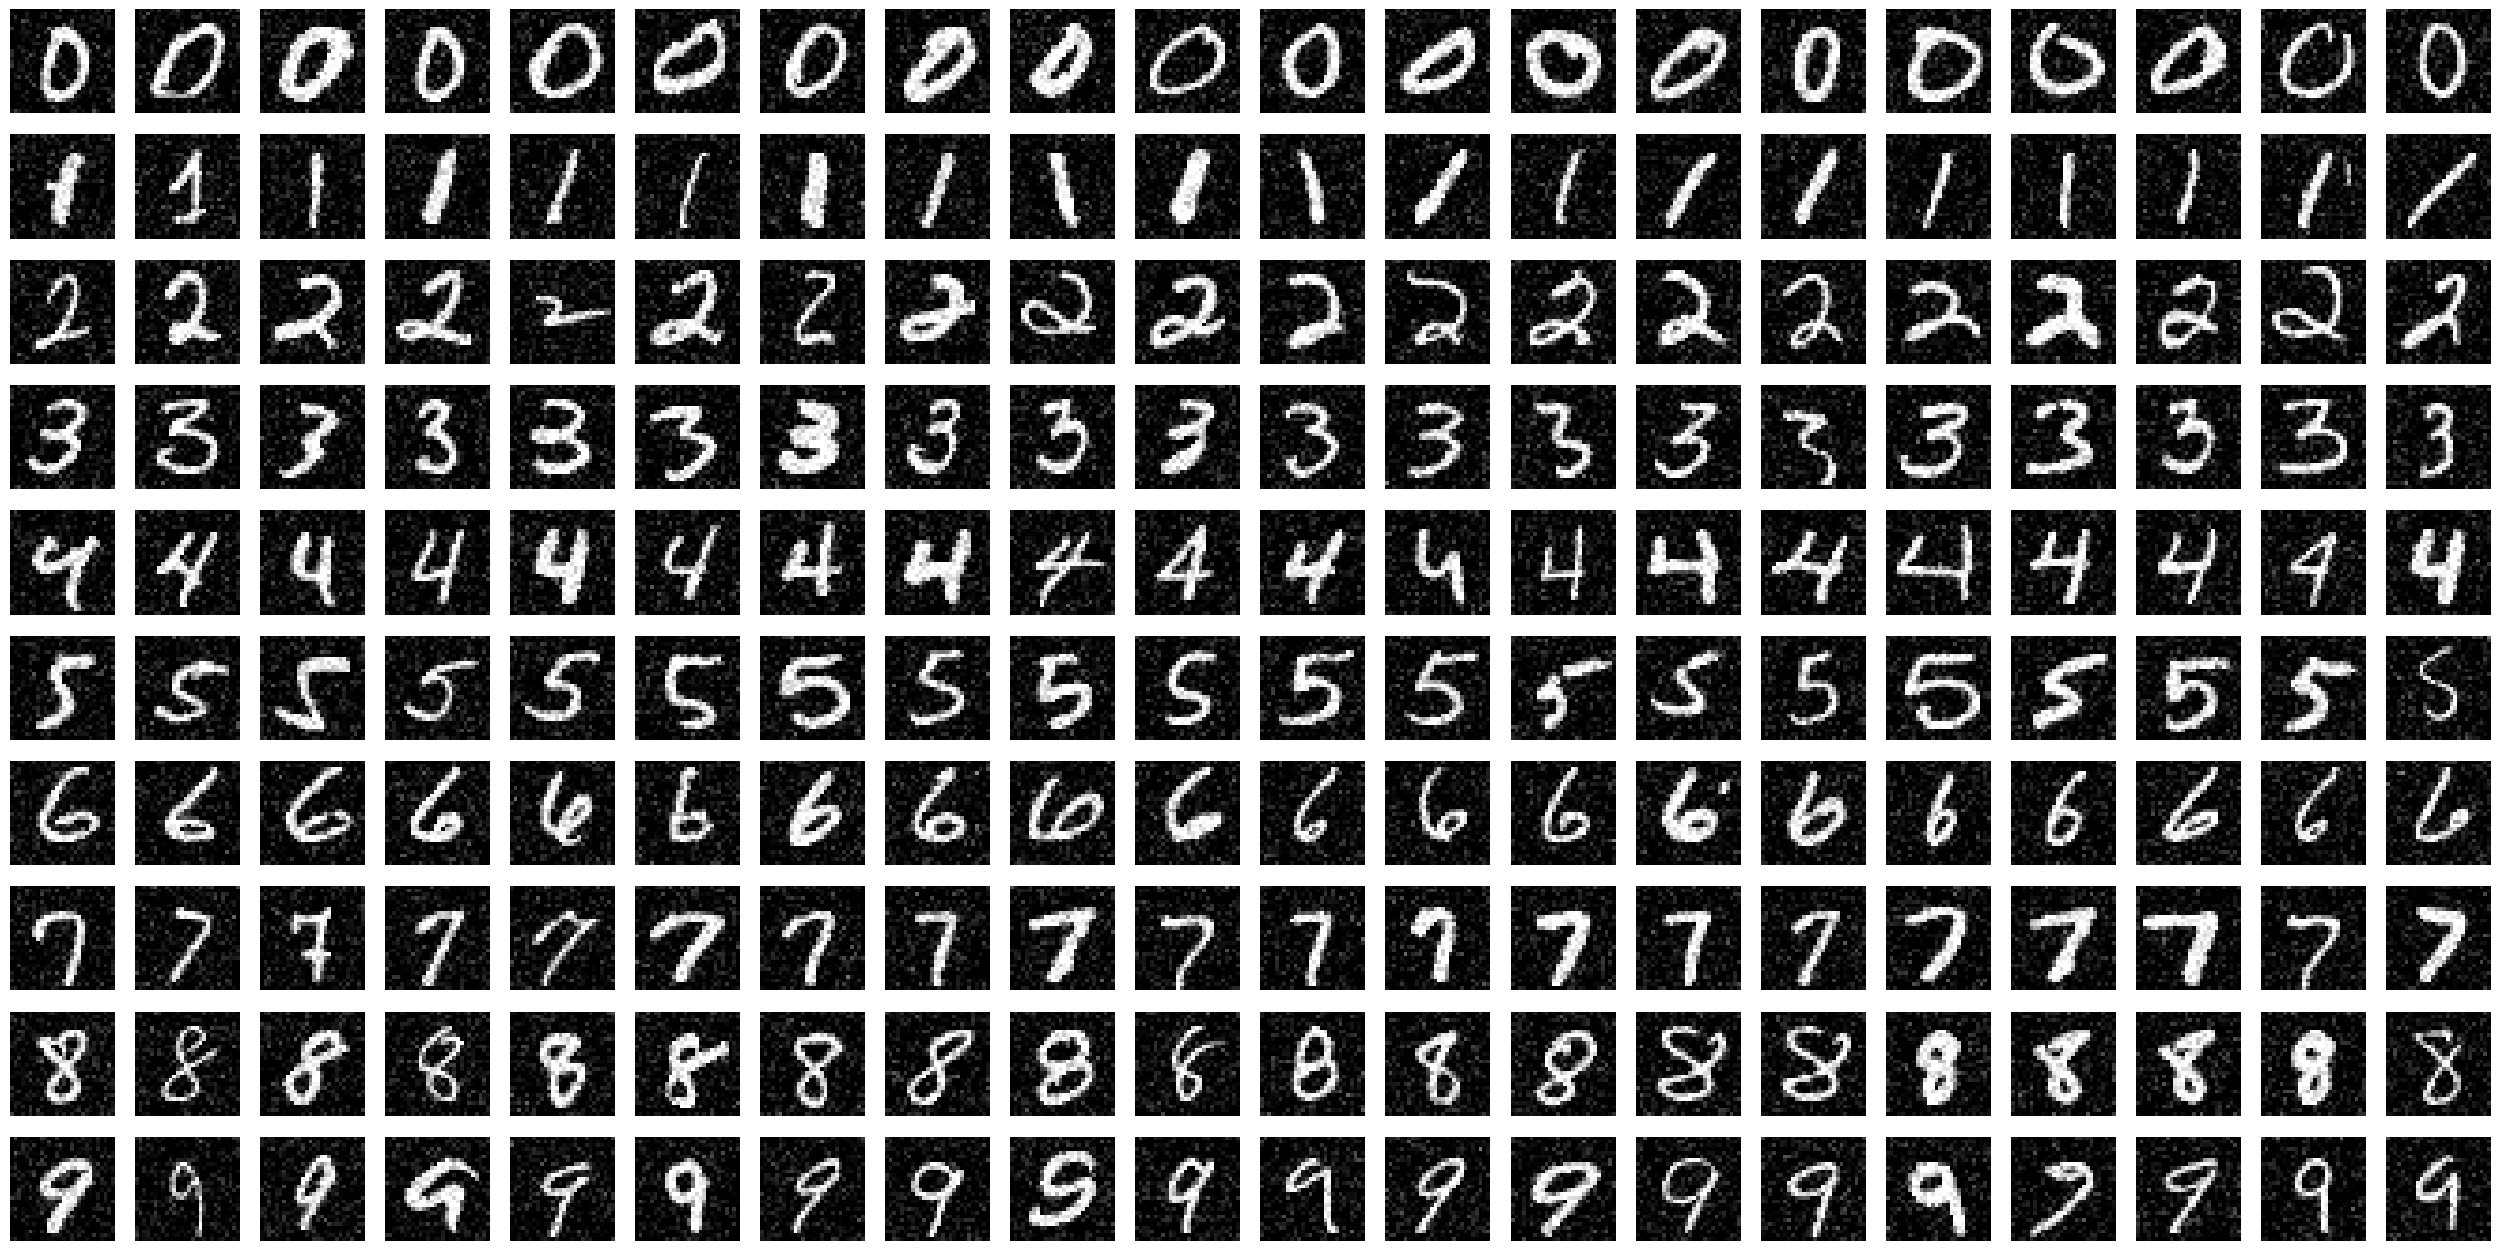

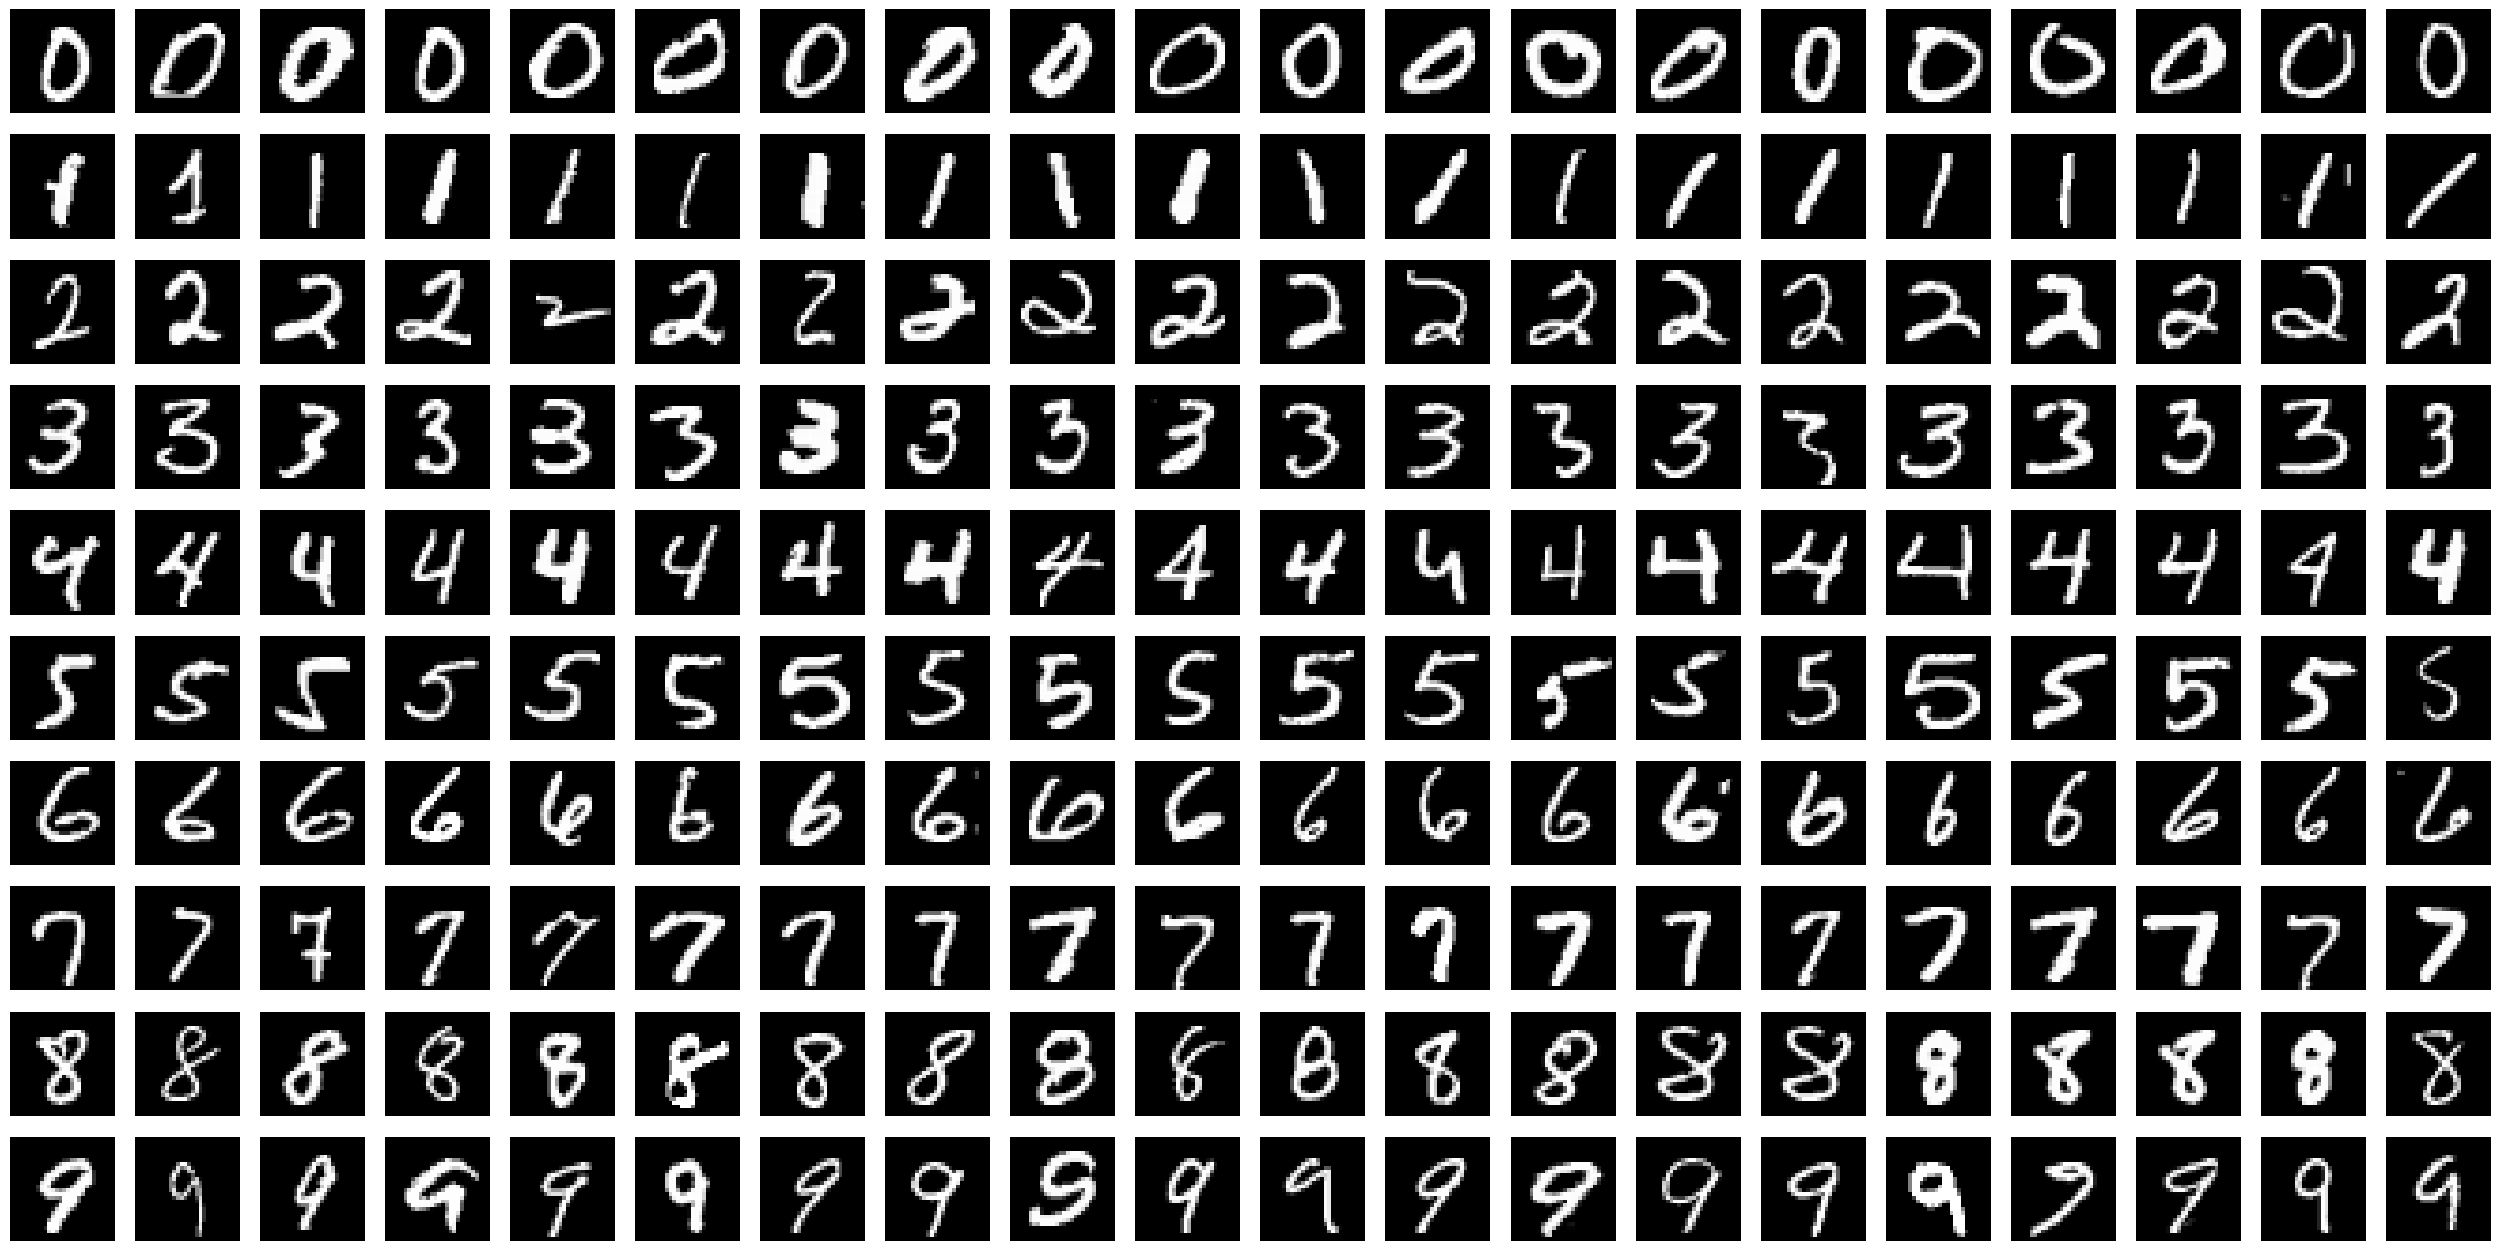

In [7]:
B_LD = ld.default_B(S, len(S), cp.get_array_module(P[0])) # Full Basis (direct fitting essentially)

sampled_P_digit = []

for digit in range(10):
    reduced_P = vectorize_tensor(P_digit[digit], B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=30).fit(reduced_P)

    # Sample new data from the KDE
    sampled_reduced_P = kde.sample(n_samples=num_new_samples)

    sampled_P = reconstruct_tensor(sampled_reduced_P, (num_new_samples, *S), B_LD)
    sampled_P_digit.append(sampled_P)

plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(sampled_P_digit[digit][i].reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_P_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

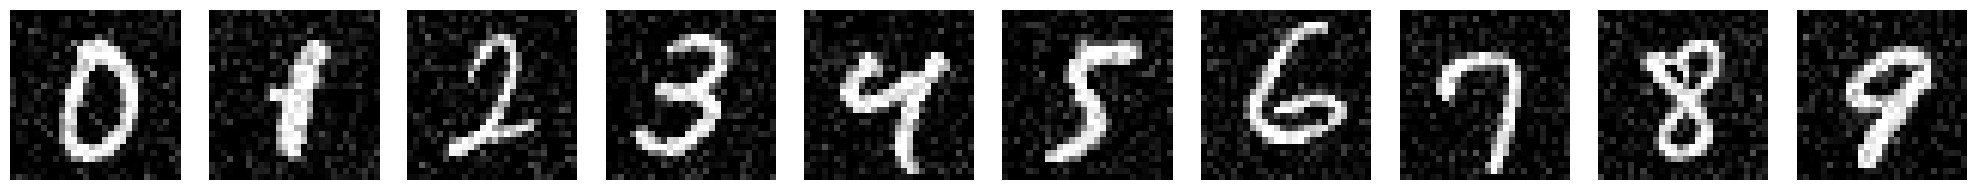

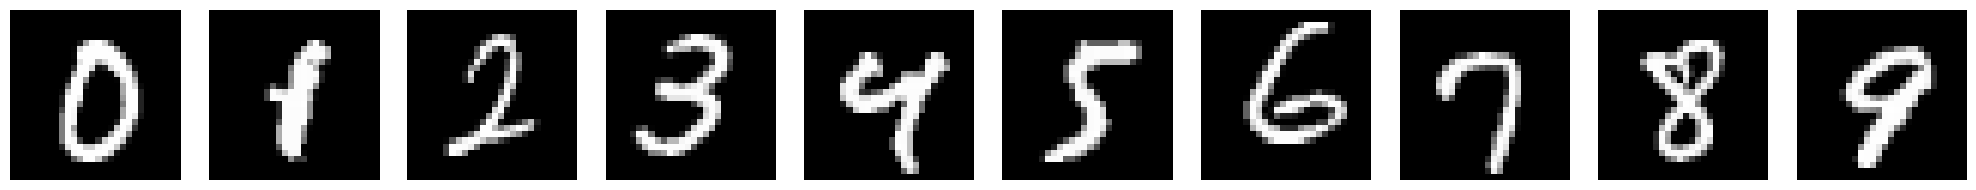

In [8]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(sampled_P_digit[digit][i].reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/else/direct_fitting.pdf', format='pdf')

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_P_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/else/direct_fitting_compare.pdf', format='pdf')

plt.show()

## Data Augmentation with Log-Linear Model

### Legendre Decomposition (Many-Body Approximation)

In [9]:
B_LD = ld.default_B(S, 1, cp.get_array_module(P[0]))

print(B_LD.shape)

def LD_helper(i, digit):
    _, _, scaleX, Q, theta = ld.LD(P_digit[digit][i], B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
    return (scaleX, Q, theta)

results = Parallel(n_jobs=30)(delayed(LD_helper)(i, digit) for i in range(train_size) for digit in range(10))

scaleX_digit = []
Q_digit = []
theta_digit = []
X_recons_digit = []

for digit in range(10):
    scaleX_list = []
    Q_list = []
    theta_list = []
    X_recons_list = []
    for i in range(train_size):
        result = results[i*10 + digit]

        scaleX_list.append(result[0])
        Q_list.append(result[1])
        theta_list.append(result[2])
        X_recons = (result[1] * result[0]).astype(np.int32)
        X_recons_list.append(X_recons)

    scaleX_digit.append(np.array(scaleX_list))
    Q_digit.append(np.array(Q_list))
    theta_digit.append(np.array(theta_list))
    X_recons_digit.append(np.array(X_recons_list))

(17, 6)


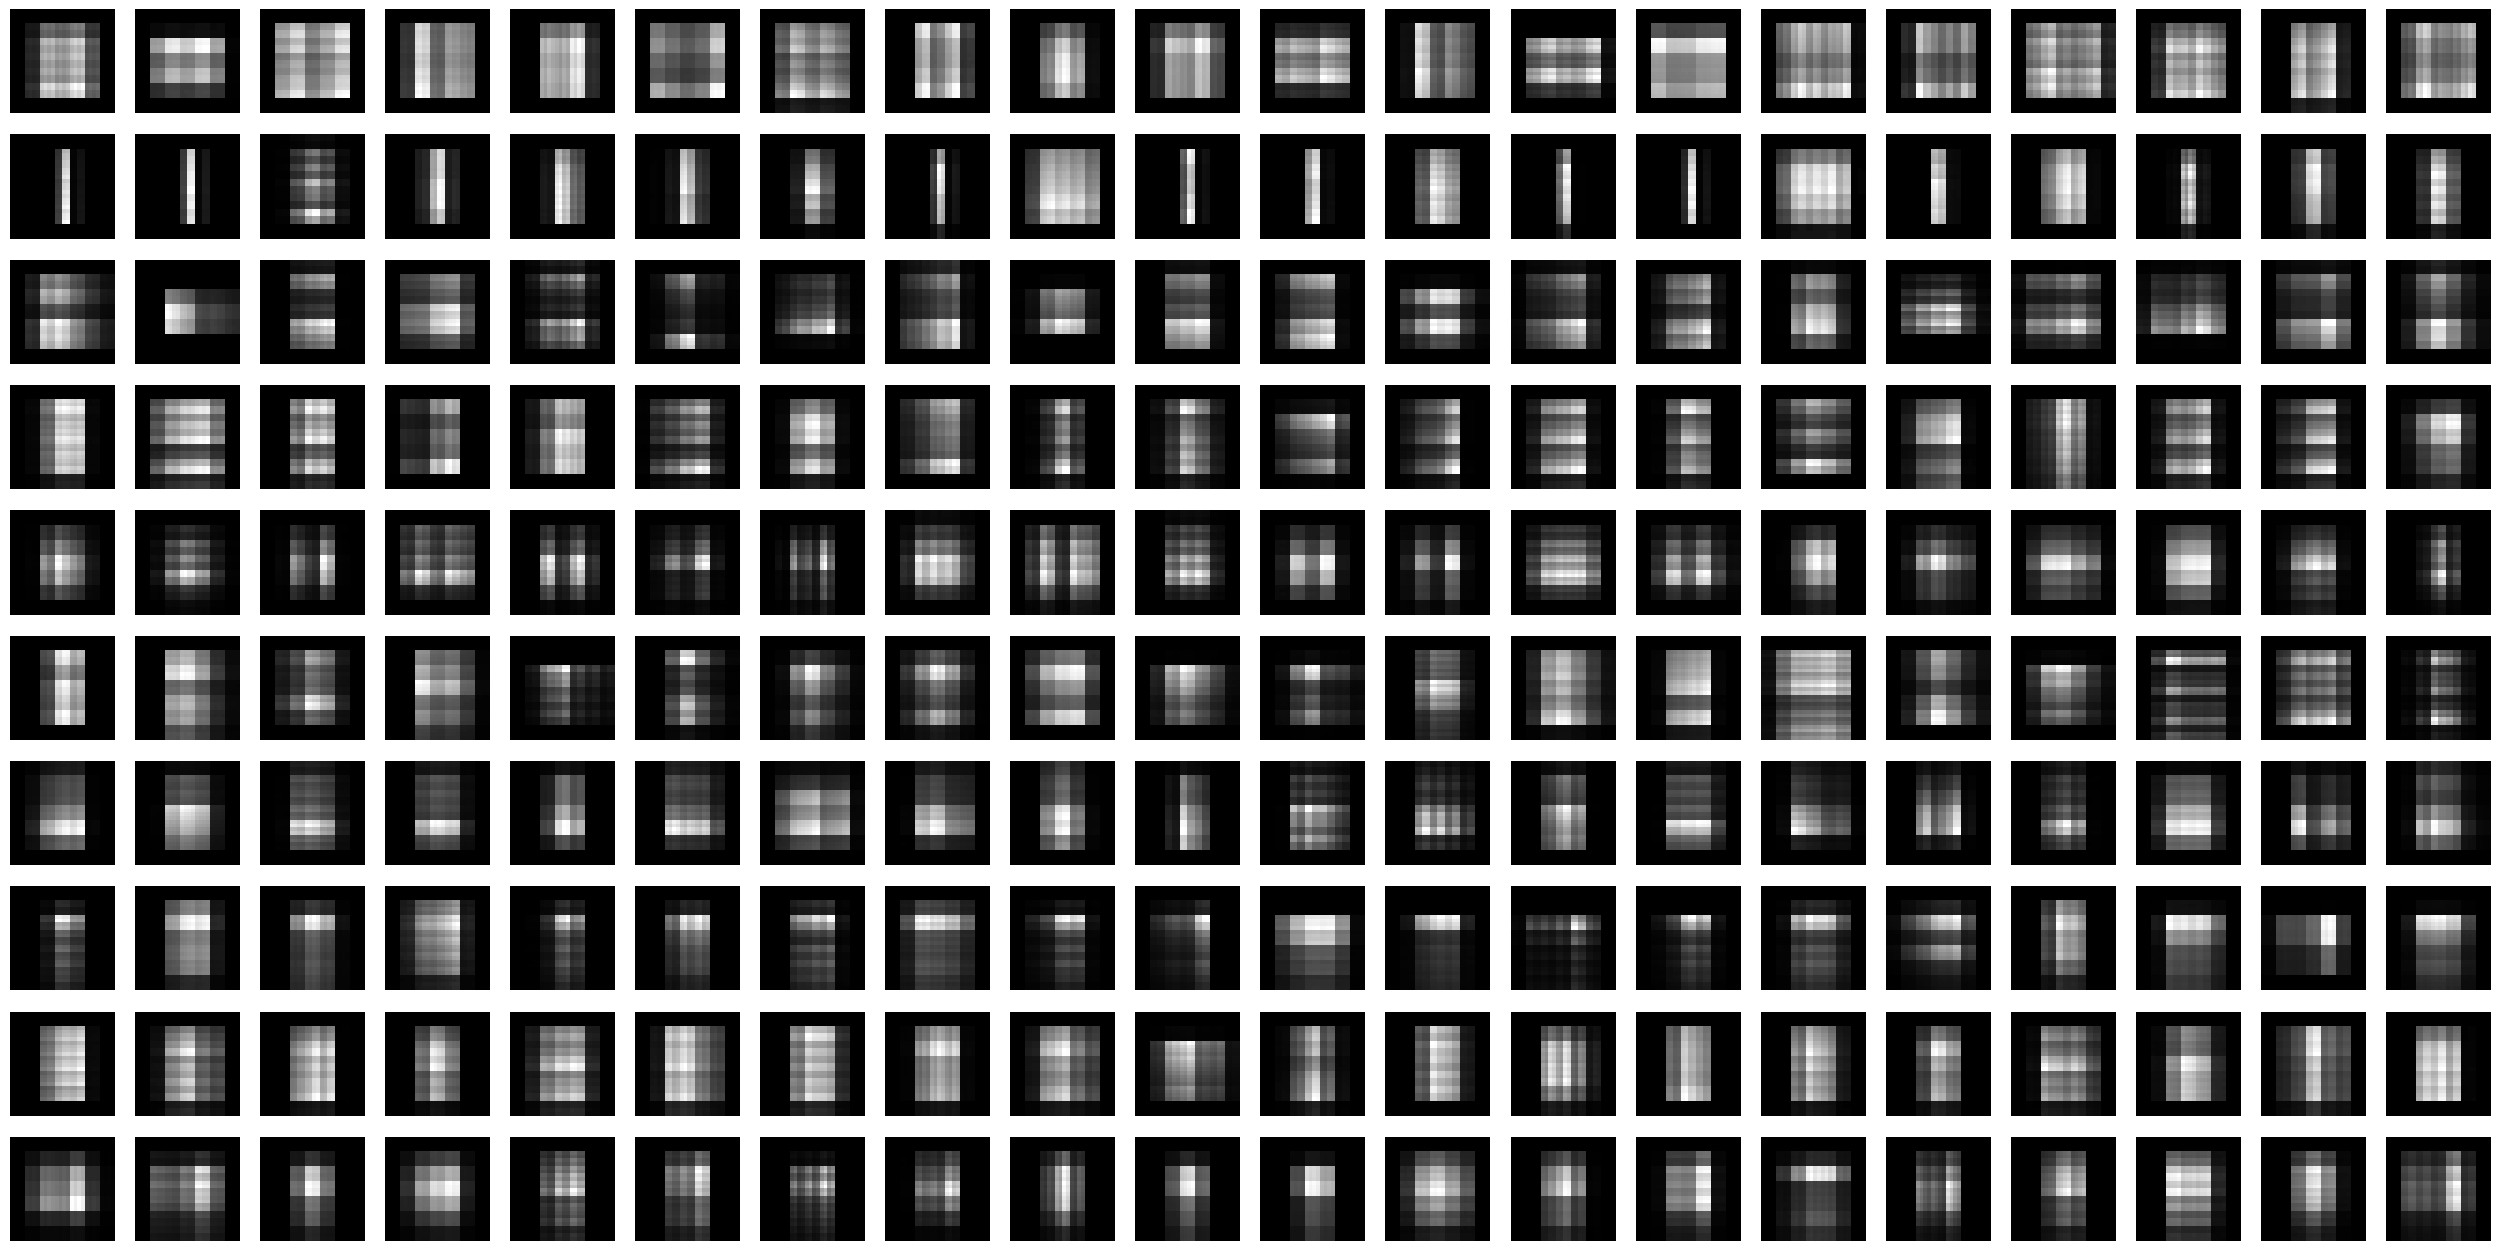

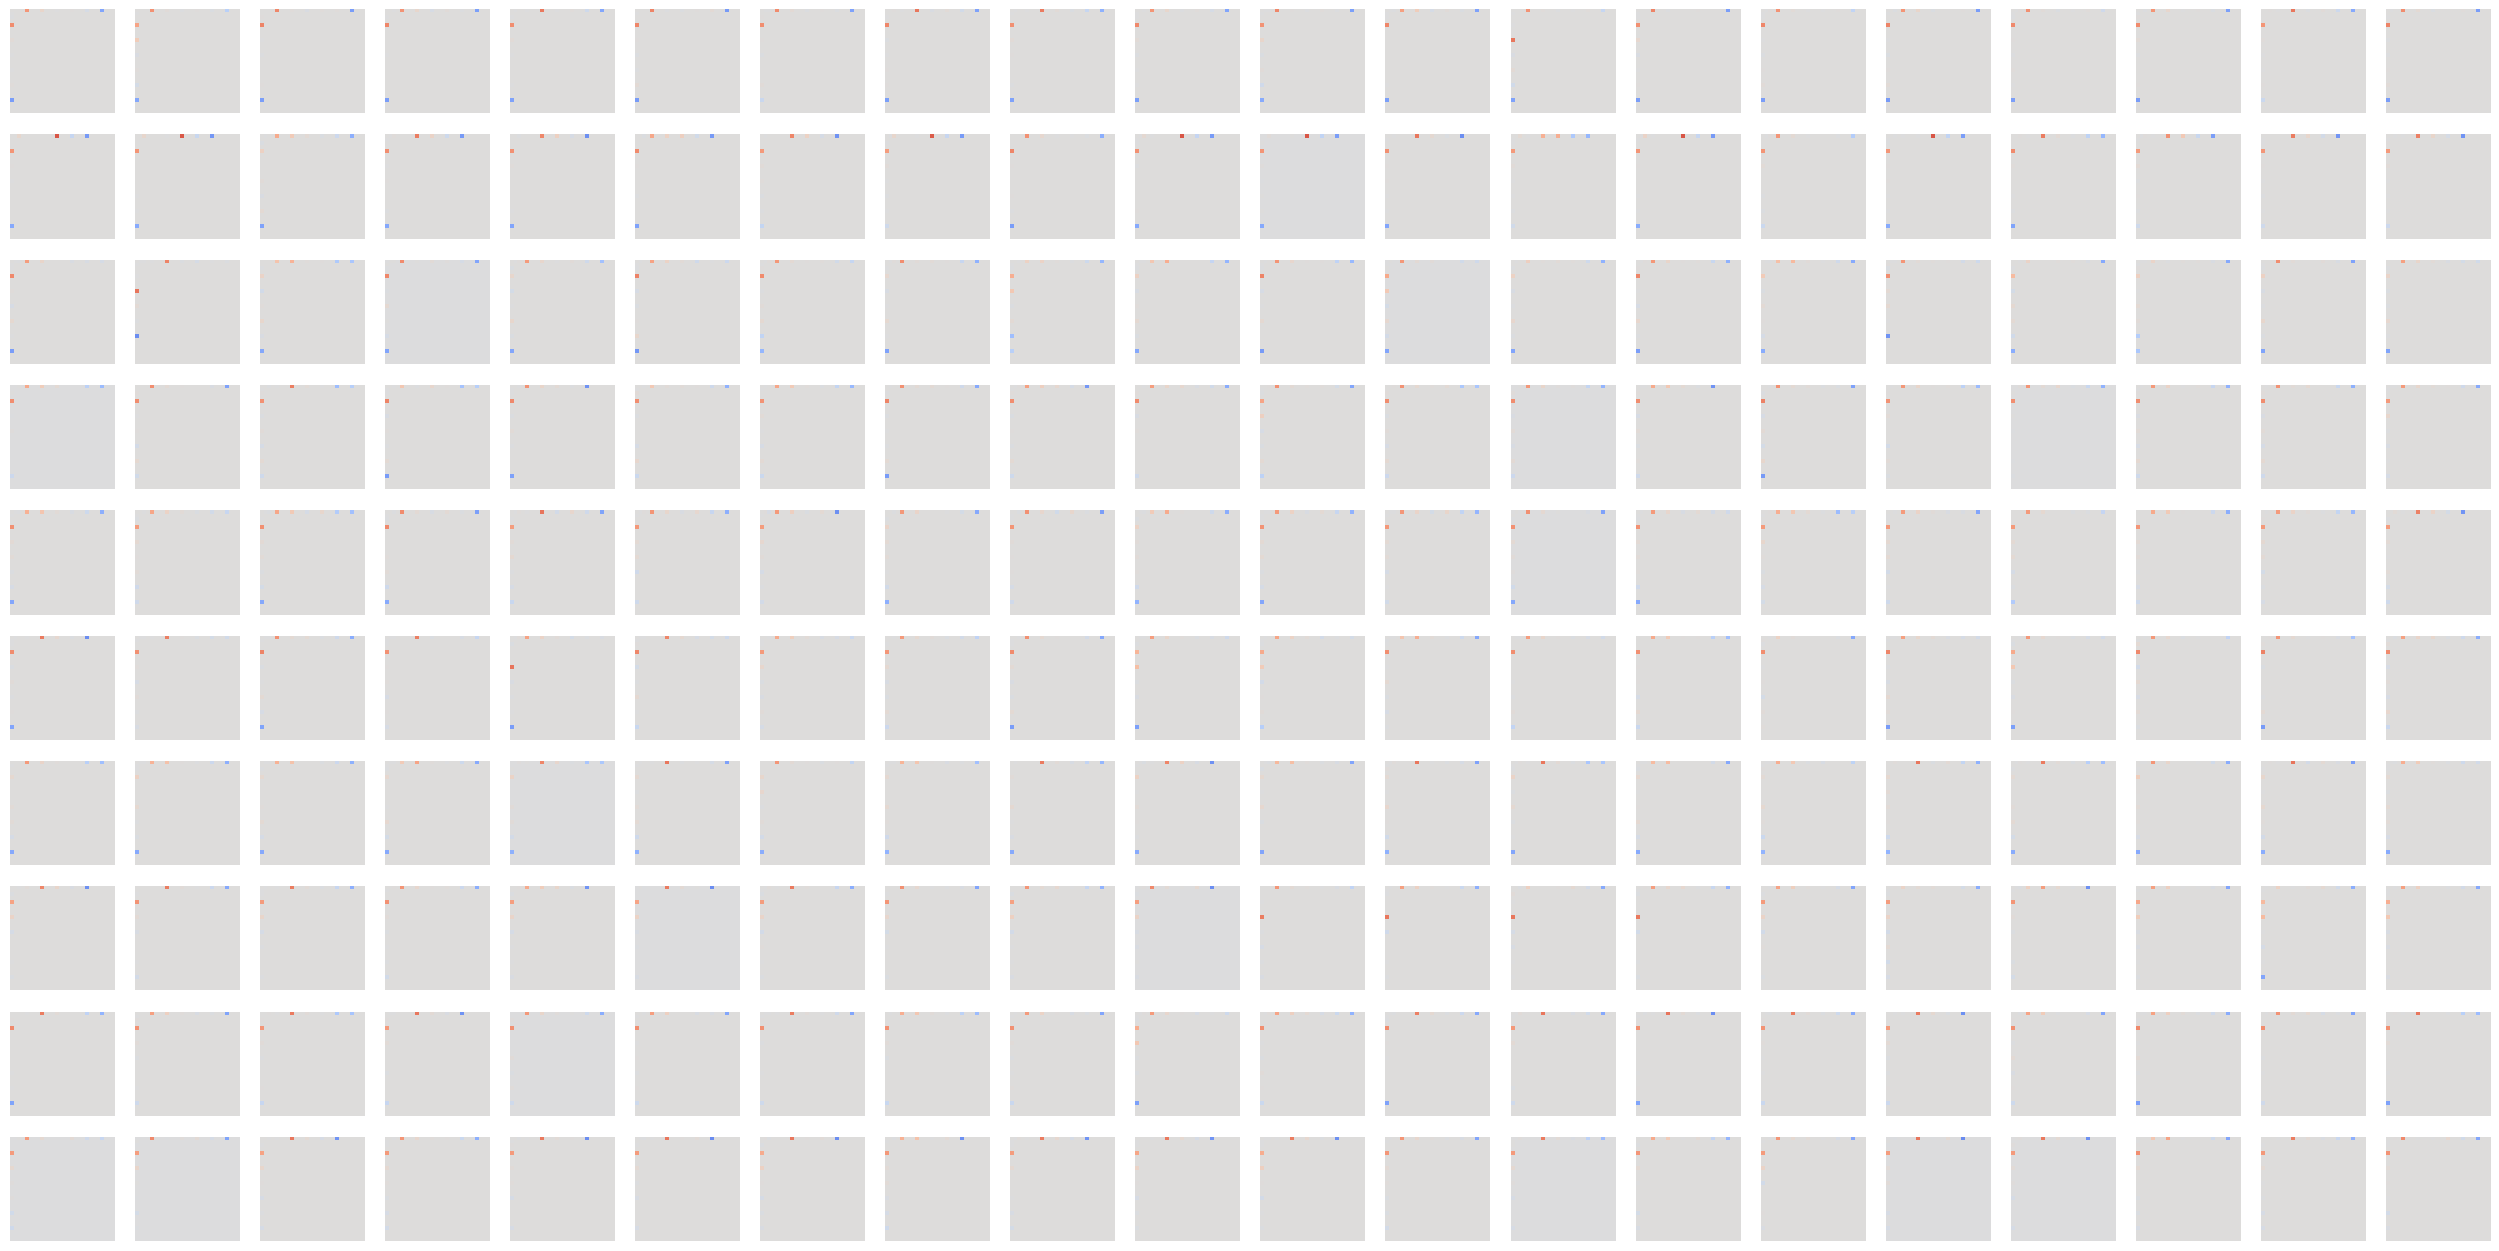

In [10]:
# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(theta_digit[digit][i].reshape((28, 28)), cmap='coolwarm', vmin=-15, vmax=15)
        plt.axis('off')  # Hide axes

plt.show()

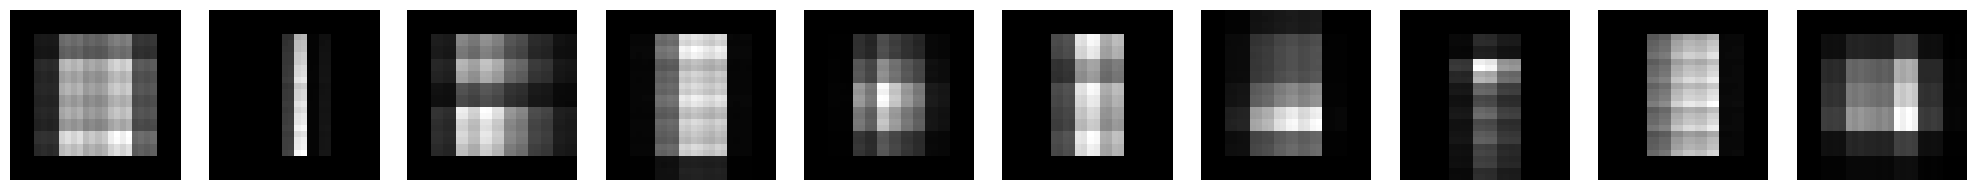

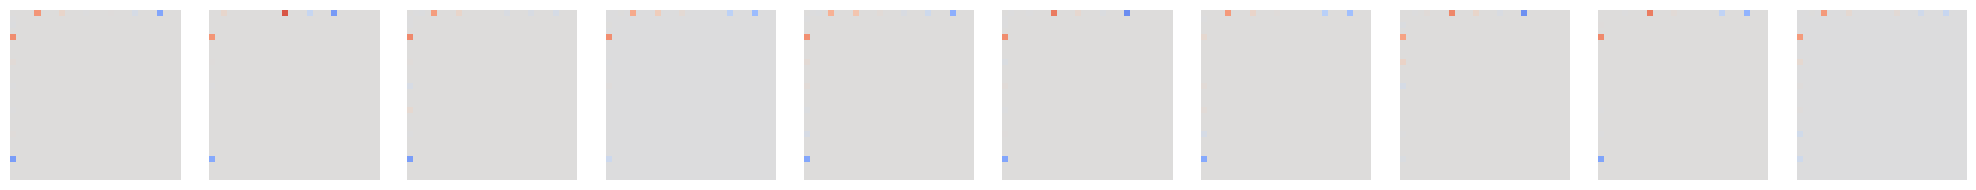

In [11]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/default_1_body_full_k=8_bandwidth=0.05/LD.pdf', format='pdf')

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(theta_digit[digit][i].reshape((28, 28)), cmap='coolwarm', vmin=-15, vmax=15)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/default_1_body_full_k=8_bandwidth=0.05/LD_parameter.pdf', format='pdf')

plt.show()

#### Fitting on Projected Points

In [12]:
sampled_theta_digit = []

for digit in range(10):
    reduced_theta = vectorize_tensor(theta_digit[digit], B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(reduced_theta)
    # Sample new data from the KDE
    sampled_reduced_theta = kde.sample(n_samples=num_new_samples)

    sampled_theta = reconstruct_tensor(sampled_reduced_theta, (num_new_samples, *S), B_LD)
    sampled_theta_digit.append(sampled_theta)

#### Construct Local-Data Sub-Manifold

In [13]:
# Construct the constrained coordinates
# B_BP = ld.block_B([14, 14], [15, 15])
B_BP = ld.default_B(S, 1, cp.get_array_module(P[0]))

print(B_BP.shape)

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_digit = []

for digit in range(10):
    eta_hat_list = []
    for i in range(P_digit[digit].shape[0]):
        xp = cp.get_array_module(P_digit[digit][i])
        P = (P_digit[digit][i] + eps) / scaleX_digit[digit][i]
        eta_hat = ld.get_eta(P, len(S), xp)
        eta_hat_list.append(eta_hat)

    eta_hat_digit.append(cp.asarray(eta_hat_list))

(17, 6)


#### Backward Projection

In [14]:
def BP_helper(i, digit):
    N = ld.kNN(sampled_theta_digit[digit][i], theta_digit[digit], k=k)
    avg_scale = np.mean(scaleX_digit[digit][N])
    avg_eta_hat = np.mean(eta_hat_digit[digit][N], axis=0)
    _, _, P, theta = ld.BP(sampled_theta_digit[digit][i], [(P_digit[digit][j] + eps) / scaleX_digit[digit][j] for j in N], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=1e-1)
    X_recons_ = (P).astype(np.int32).reshape(-1)
    return (P, theta, X_recons_)

results = Parallel(n_jobs=30)(delayed(BP_helper)(i, digit) for i in range(num_new_samples) for digit in range(10))

sampled_P_BP_digit = []
sampled_theta_BP_digit = []
sampled_X_recons_digit = []

for digit in range(10):
    sampled_P_BP = []
    sampled_theta_BP = []
    sampled_X_recons = []
    for i in range(num_new_samples):
        result = results[i*10 + digit]

        sampled_P_BP.append(result[0])
        sampled_theta_BP.append(result[1])
        sampled_X_recons.append(result[2])

    sampled_P_BP_digit.append(np.array(sampled_P_BP))
    sampled_theta_BP_digit.append(np.array(sampled_theta_BP))
    sampled_X_recons_digit.append(np.array(sampled_X_recons))

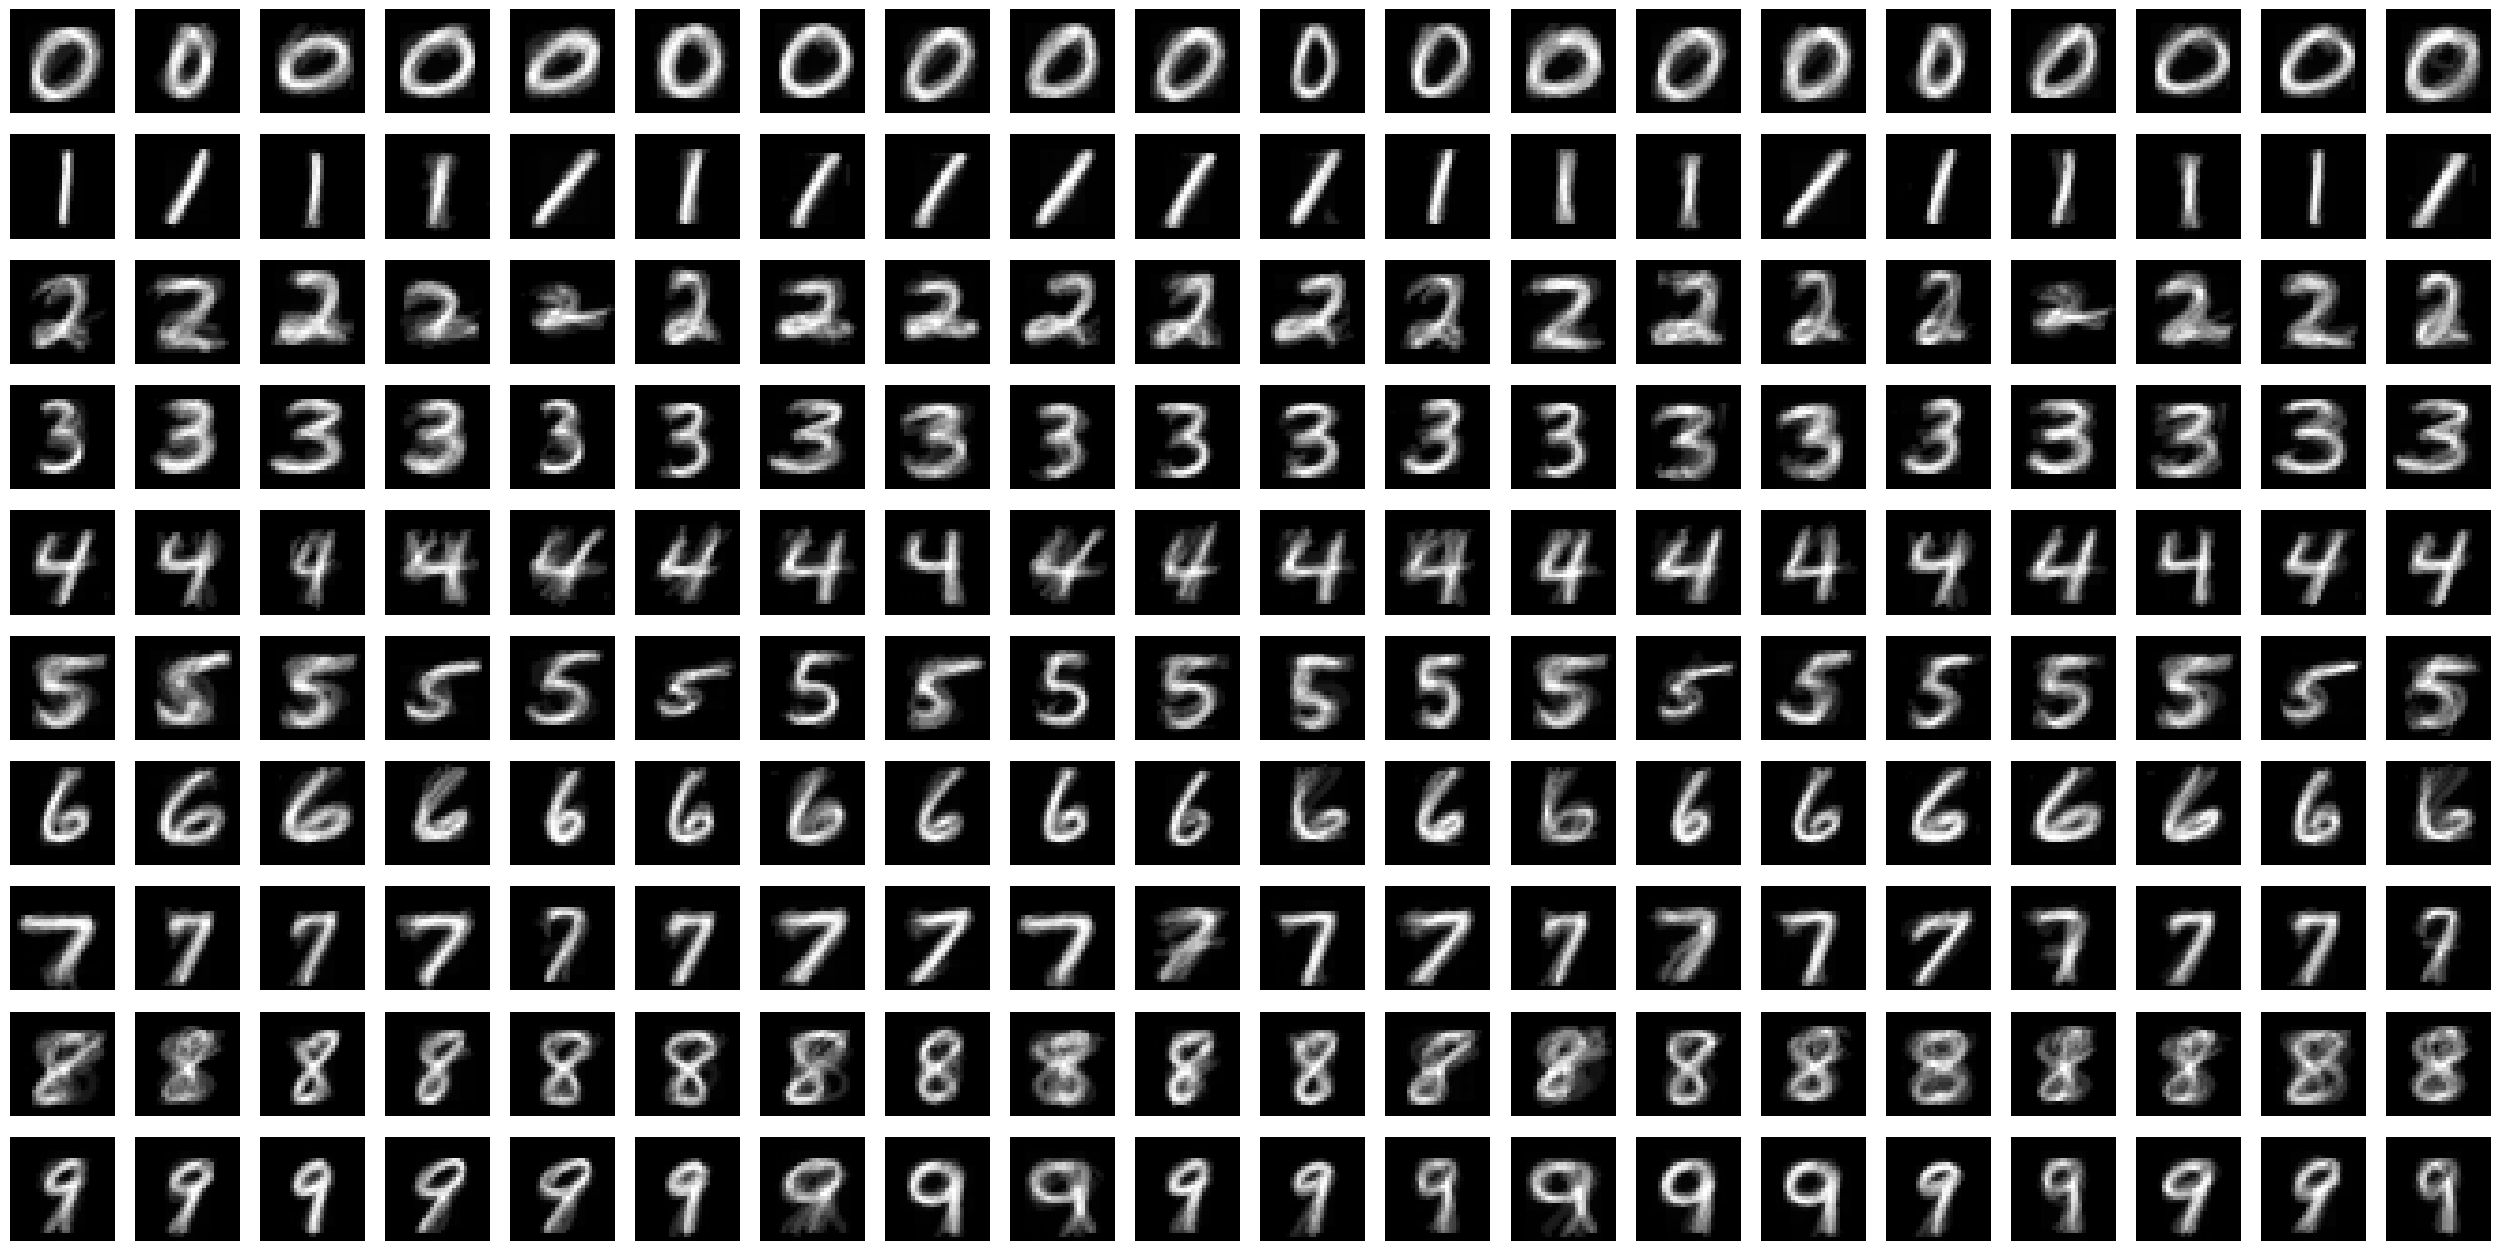

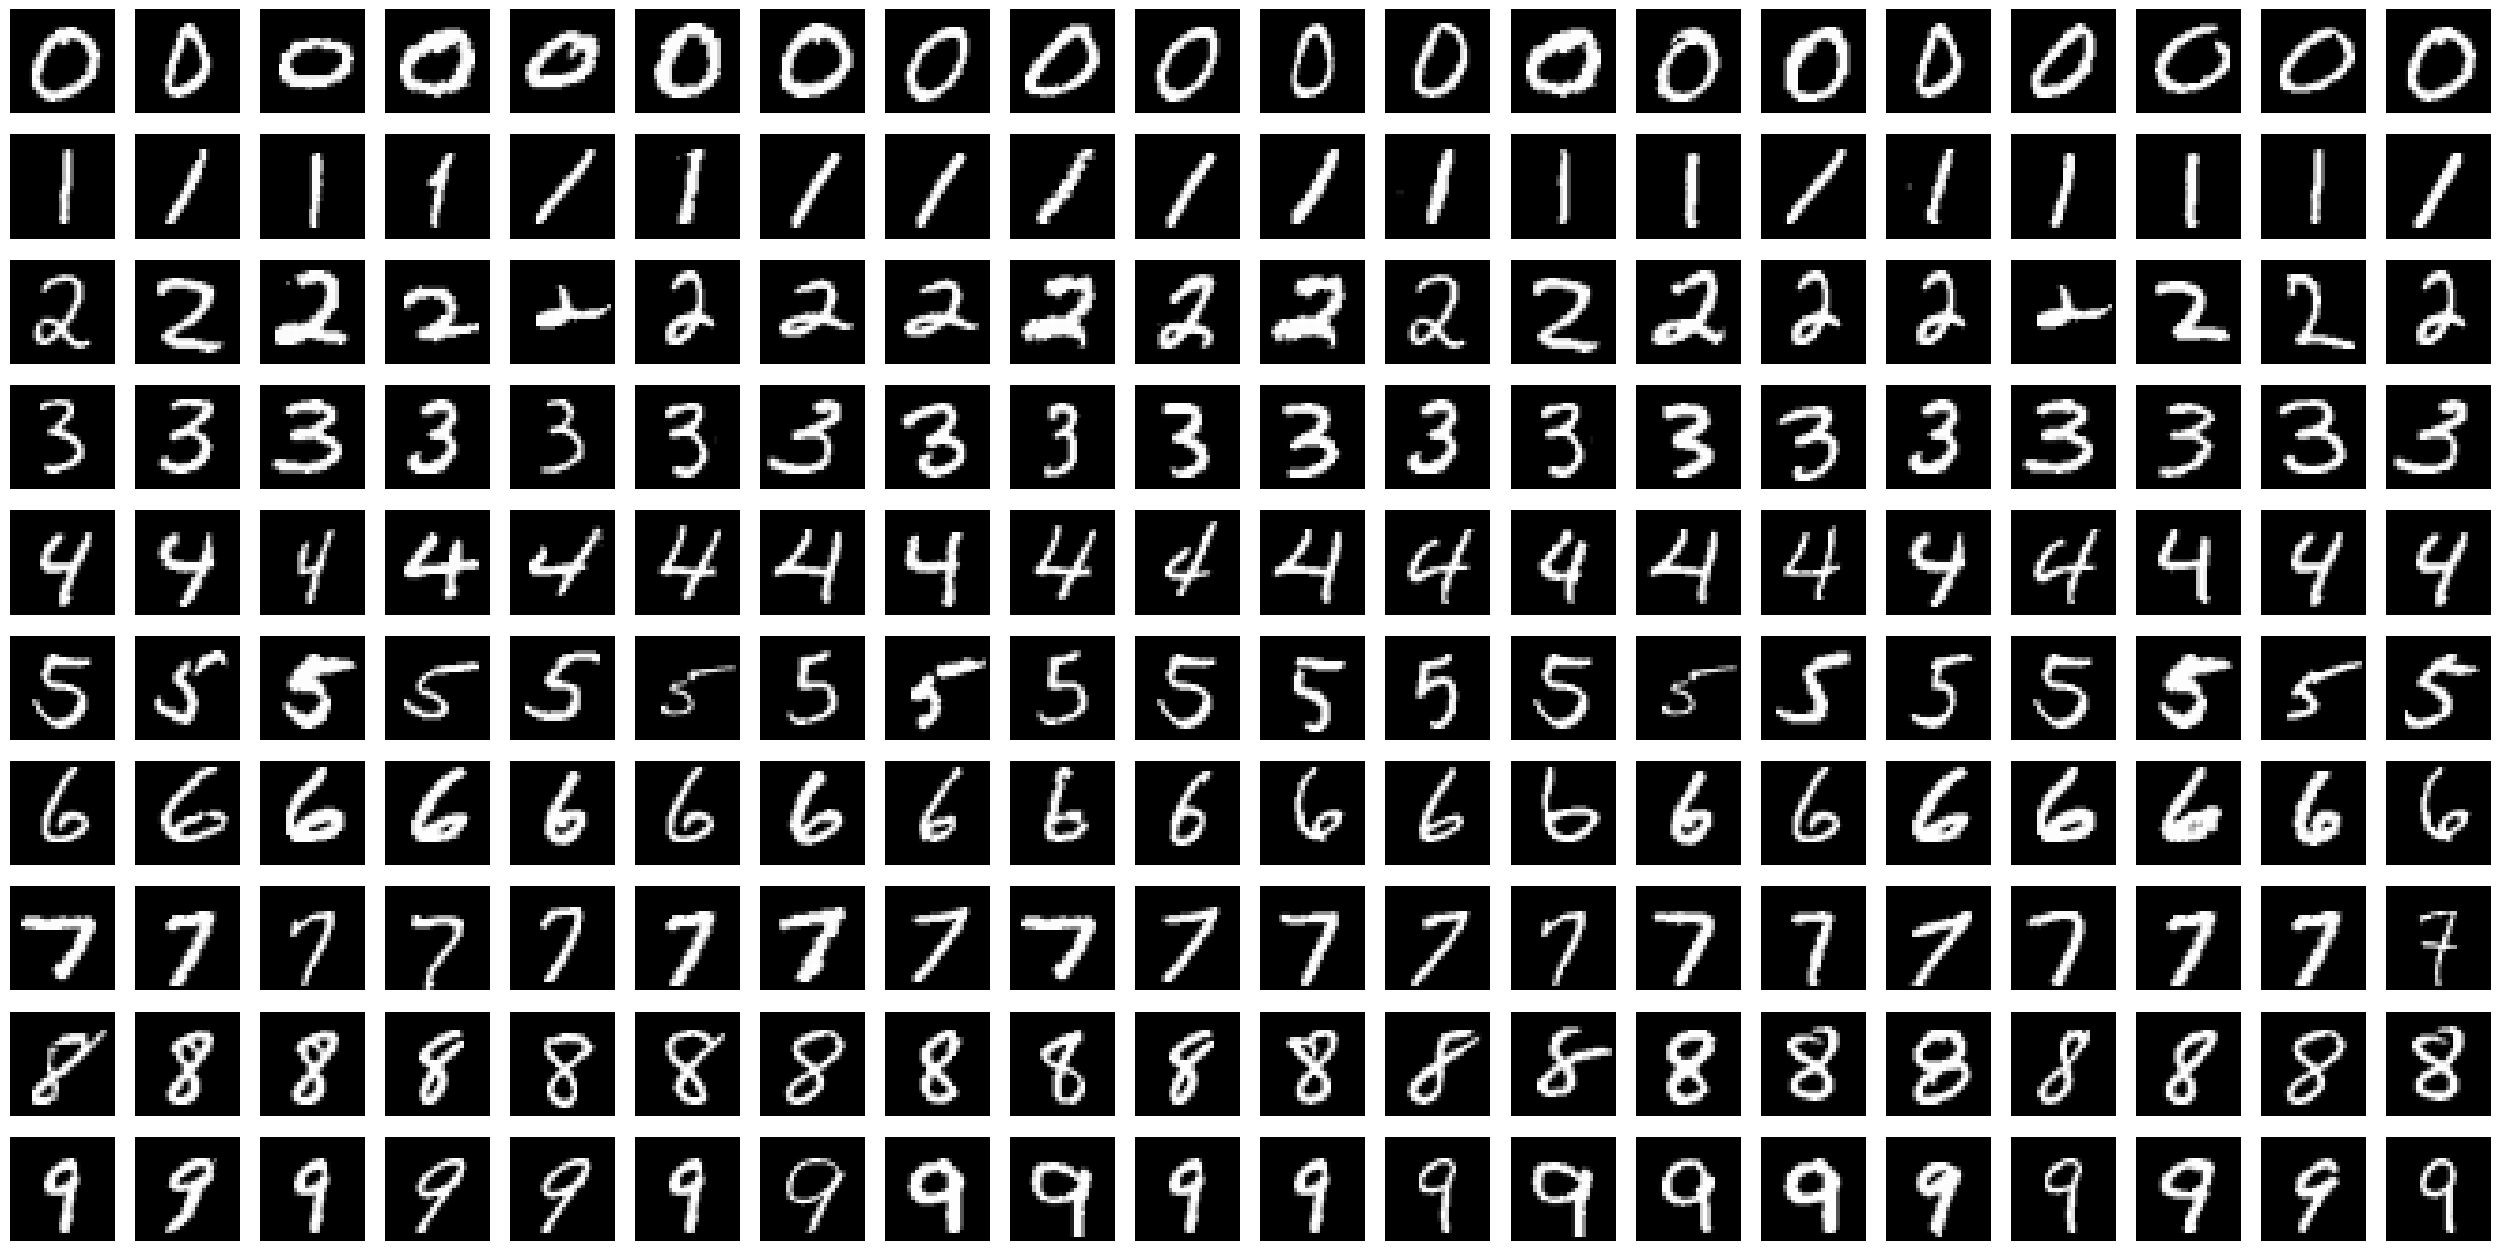

In [15]:
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_X_recons_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

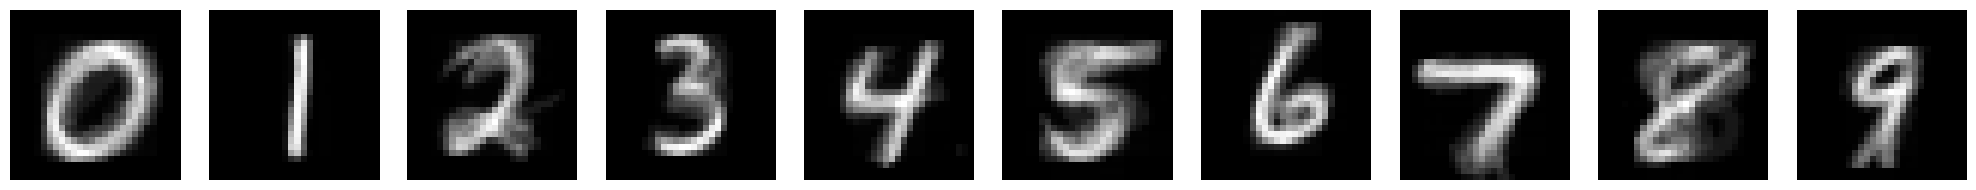

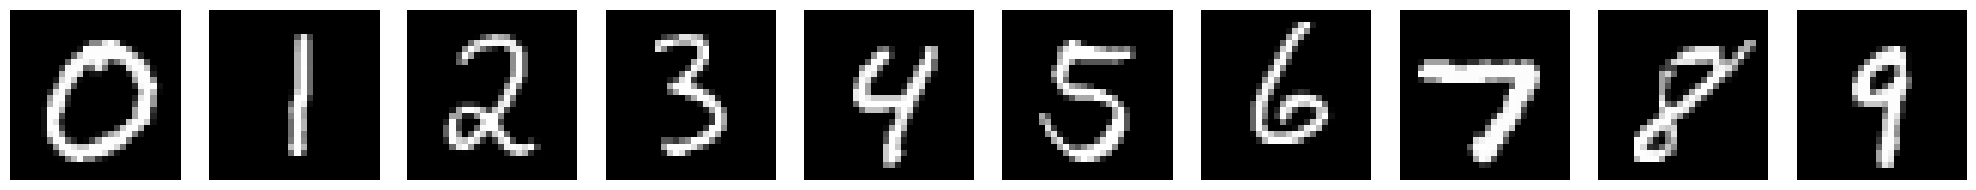

In [16]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/default_1_body_full_k=8_bandwidth=0.05/BP.pdf', format='pdf')

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_X_recons_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/default_1_body_full_k=8_bandwidth=0.05/BP_compare.pdf', format='pdf')

plt.show()

### Store Augmented Data

In [17]:
augmented_data_LD = []

for digit in range(10):
    for i in range(num_new_samples):
        img = renormalize_image(sampled_X_recons_digit[digit][i]).reshape((28, 28))
        augmented_data_LD.append(img)

train_data_LD = np.array(augmented_data_LD)
labels = np.repeat(np.arange(10), num_new_samples)
custom_train_dataset = CustomDataset(train_data_LD, labels, transform=transforms.ToTensor())
train_loader_LD = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)

## Data Augmentation with Autoencoder

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, z_dim=B_LD.shape[0]):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.fc2 = nn.Linear(hidden_size , hidden_size2)
        self.fc3 = nn.Linear(hidden_size, z_dim)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self, output_size=28*28, hidden_size=128, z_dim=B_LD.shape[0]):
        super().__init__()
        self.fc1 = nn.Linear(z_dim , hidden_size)
        # self.fc2 = nn.Linear(hidden_size , hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [19]:
enc = Encoder().to(device)
dec = Decoder().to(device)
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

100%|██████████| 500/500 [08:50<00:00,  1.06s/it]


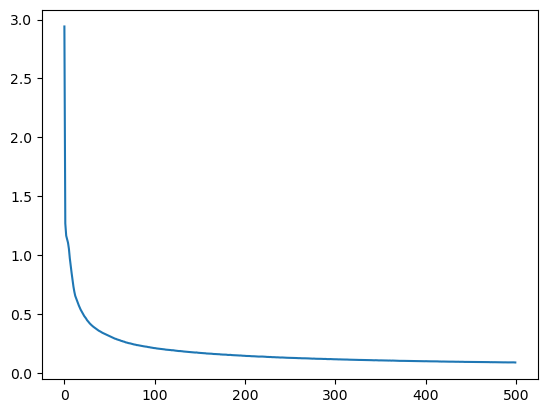

In [20]:
train_loss = []
num_epochs = 500

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = 0
    for (imgs , _) in train_loader_original:
        imgs = imgs.to(device)
        #100 , 1 , 28 , 28 ---> (100 , 28*28)
        imgs = imgs.flatten(1)
        latents = enc(imgs)
        output = dec(latents)
        loss = loss_fn(output , imgs)
        train_epoch_loss += loss.cpu().detach().numpy()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
    train_loss.append(train_epoch_loss)
plt.plot(train_loss)

In [21]:
representation = None
AE_imgs = None
all_labels = []

with torch.no_grad():
    for (imgs , labels) in train_loader_original:
        imgs = imgs.to(device)
        imgs = imgs.flatten(1)
        all_labels.extend(list(labels.numpy()))
        latents = enc(imgs)
        if representation is None:
            representation = latents.cpu()
        else:
            representation = torch.vstack([representation , latents.cpu()])

        if AE_imgs is None:
            AE_imgs = imgs.detach().cpu().numpy()
        else:
            AE_imgs = np.vstack([AE_imgs , imgs.detach().cpu().numpy()])

AE_digit = []
for digit in range(10):
    AE_digit.append(AE_imgs[torch.tensor(all_labels) == digit])

all_labels = np.array(all_labels)
representation = representation.numpy()

In [22]:
sampled_AE_digit = []

for digit in range(10):
    sampled_AE_list = []

    rep = representation[np.argwhere(all_labels == digit)].squeeze()
    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_AE).fit(rep)

    # Sample new data from the KDE
    sampled_rep = kde.sample(n_samples=num_new_samples)
    for i in range(num_new_samples):
        pred = dec(torch.Tensor(sampled_rep[i])[None , ...].to(device)).cpu().detach().numpy()
        sampled_AE_list.append(pred)

    sampled_AE_digit.append(sampled_AE_list)

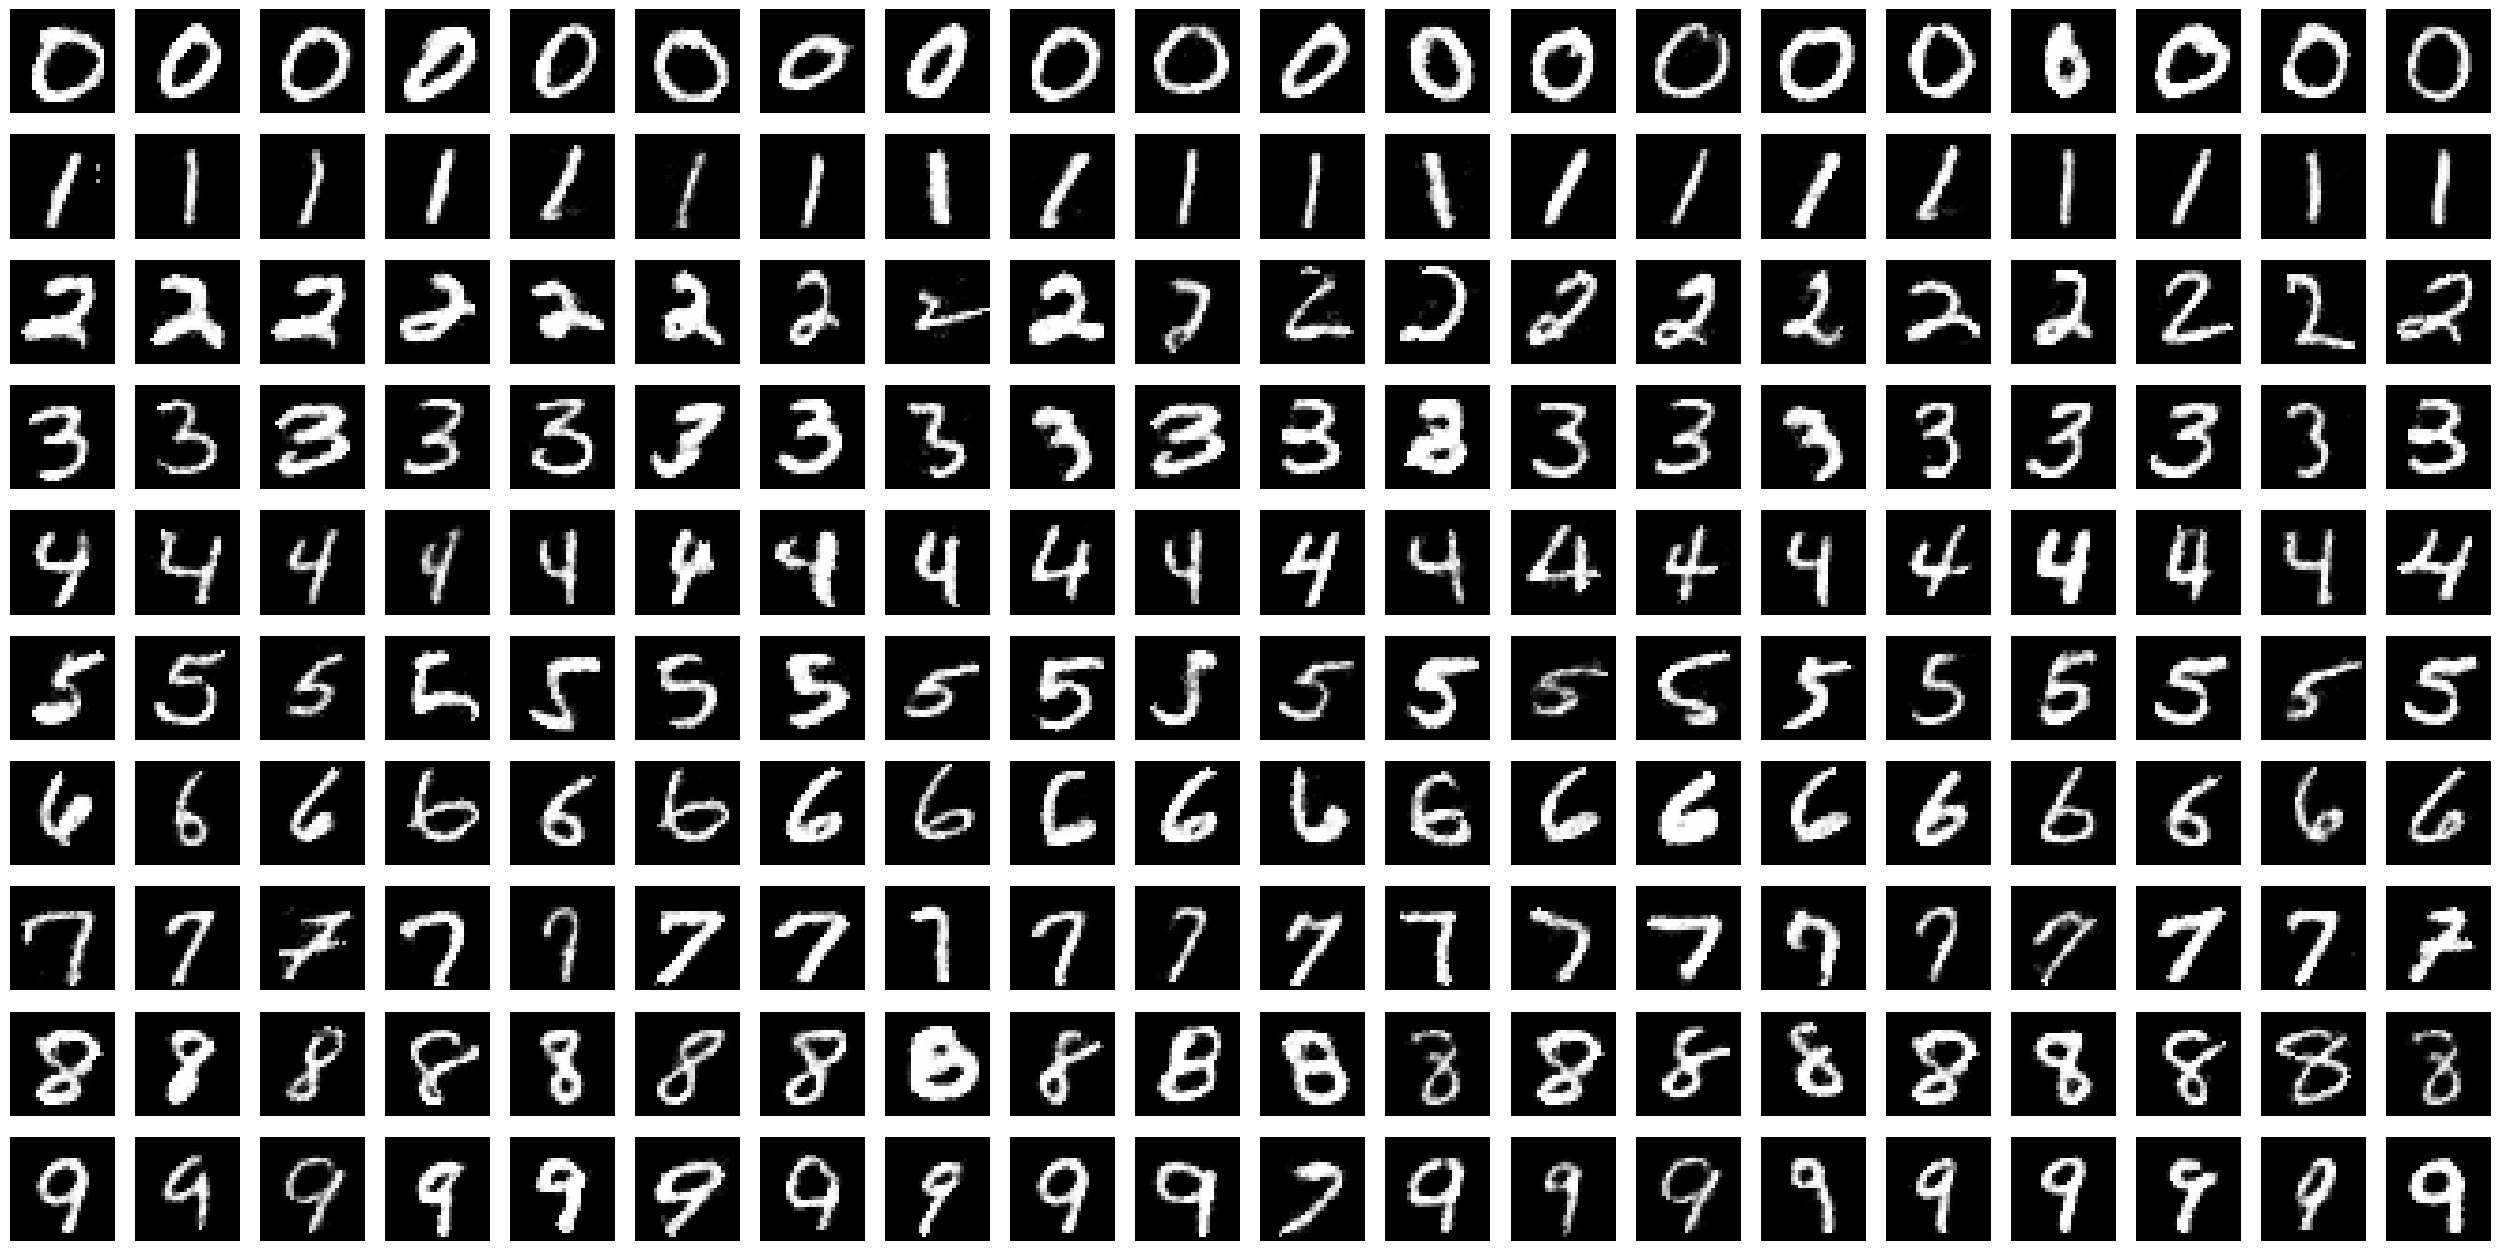

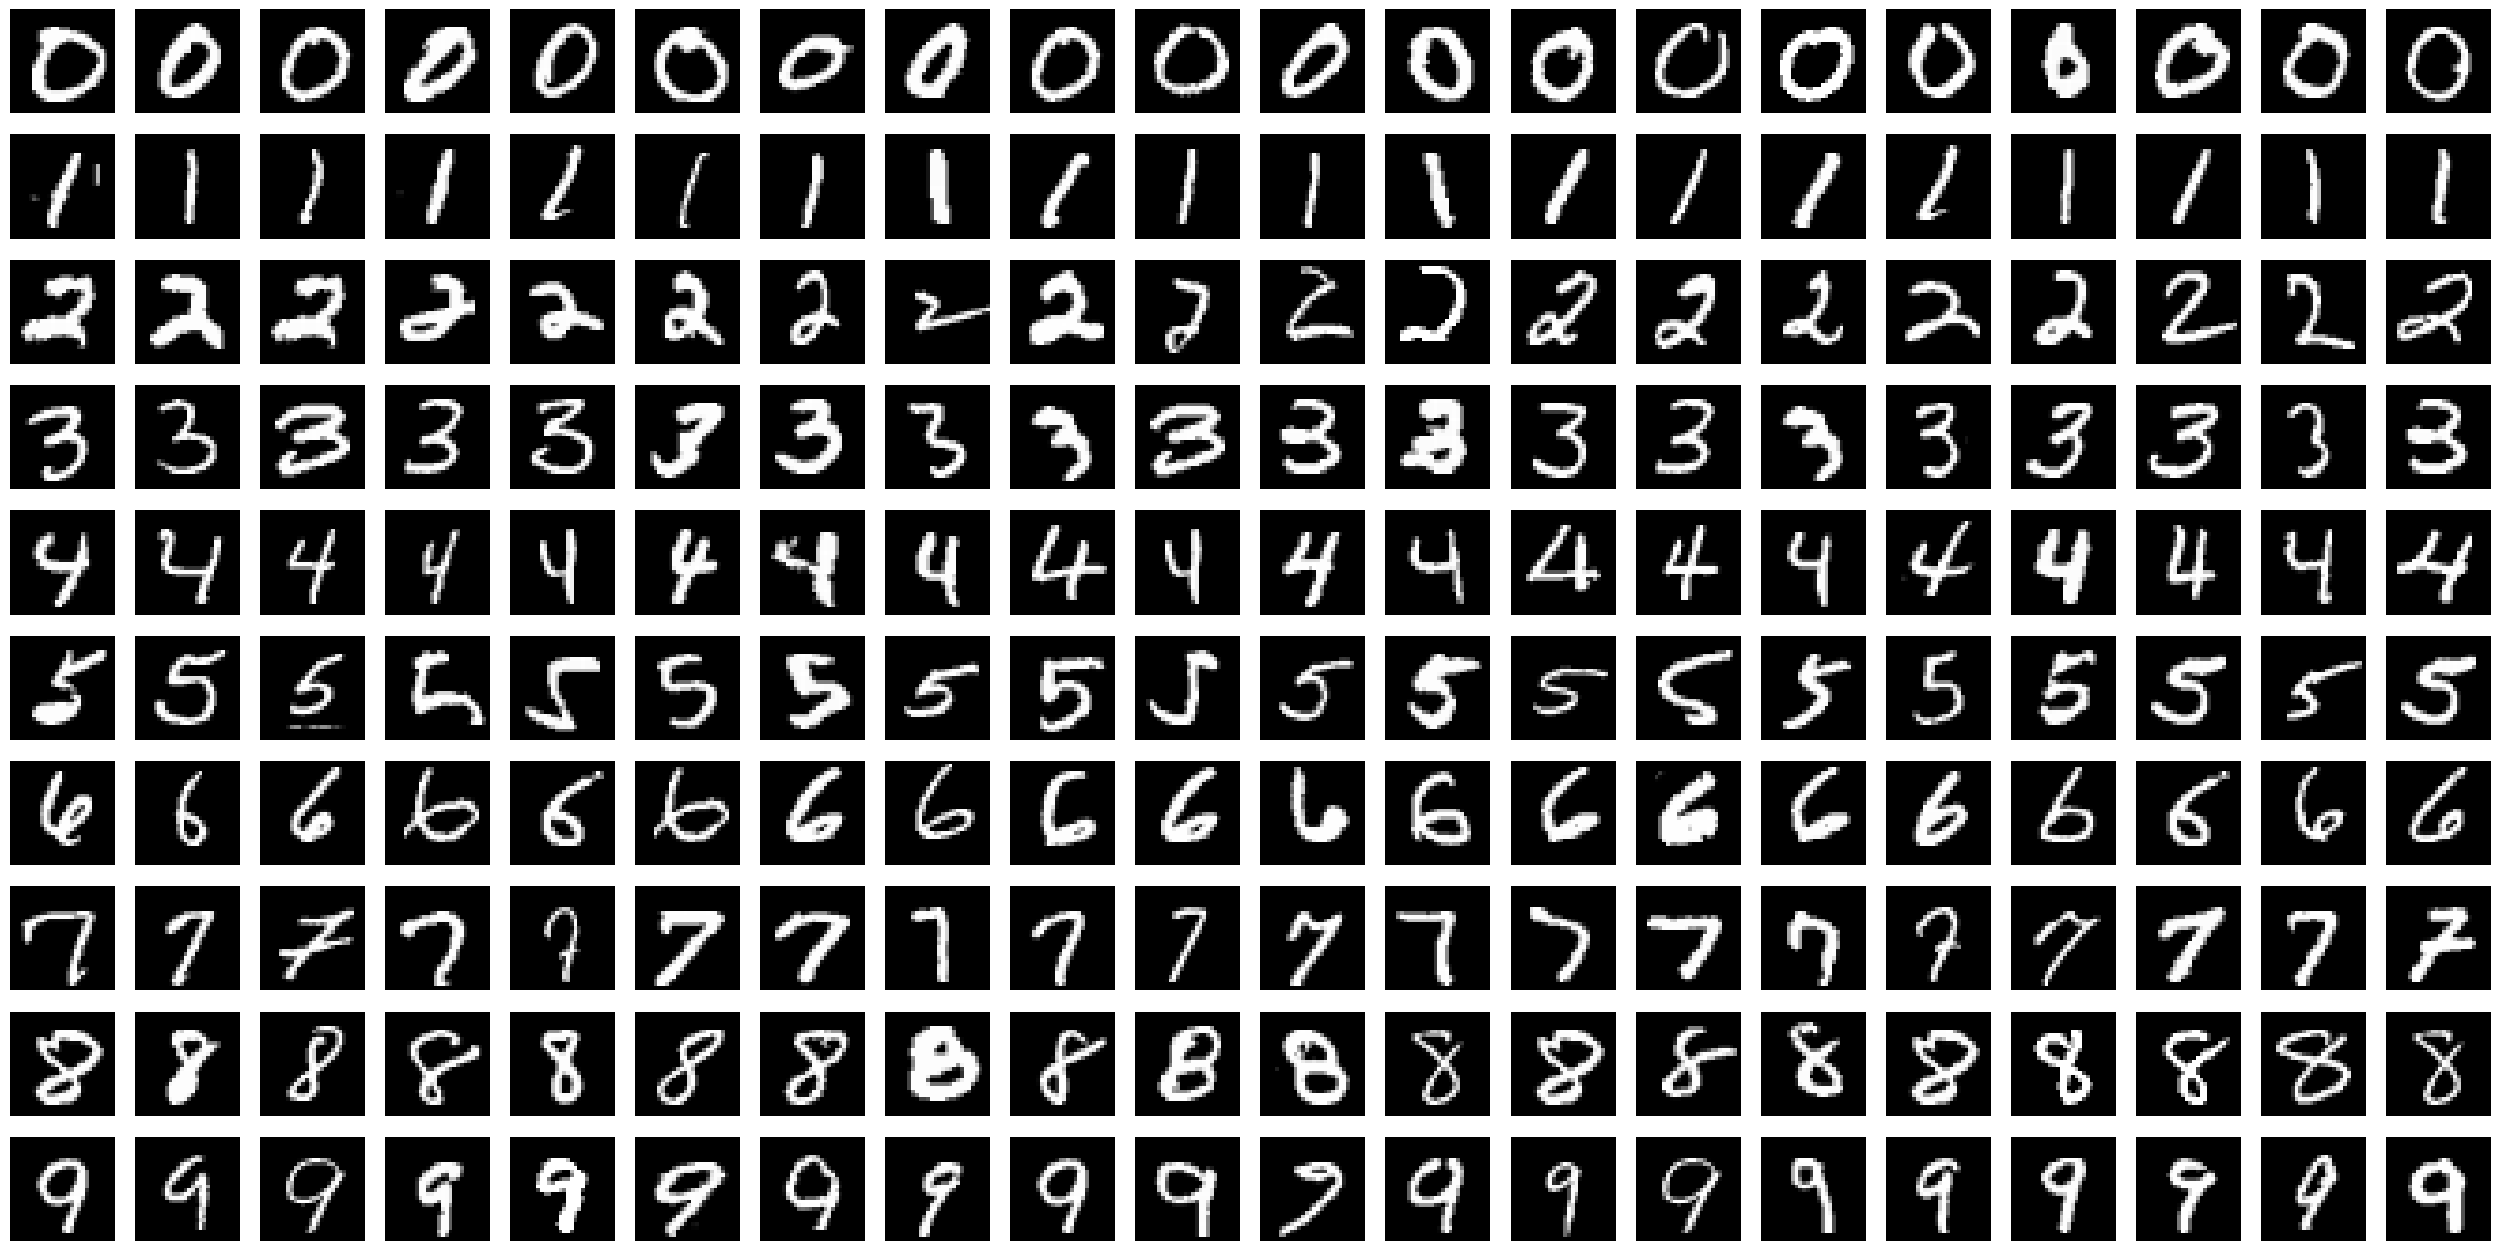

In [23]:
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_AE_digit[digit][i]).reshape(28, 28), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_AE_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in AE_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(AE_digit[digit][idx]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

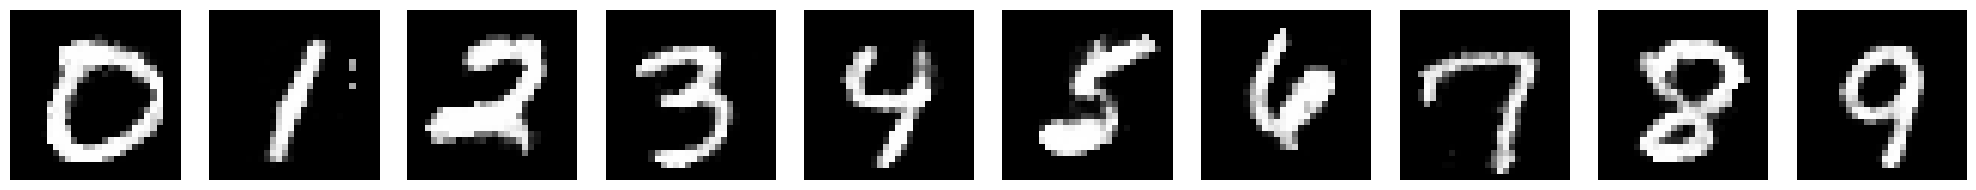

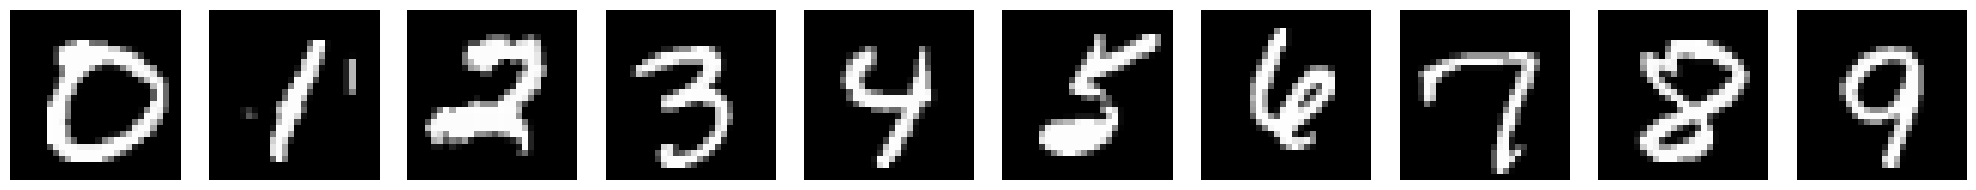

In [24]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_AE_digit[digit][i]).reshape(28, 28), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/else/AE.pdf', format='pdf')

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_AE_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in AE_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(AE_digit[digit][idx]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/else/AE_compare.pdf', format='pdf')

plt.show()

### Store Augmented Data

In [25]:
augmented_data_AE = []

for digit in range(10):
    for i in range(num_new_samples):
        img = renormalize_image(sampled_AE_digit[digit][i]).reshape((28, 28))
        augmented_data_AE.append(img)

train_data_AE = np.array(augmented_data_AE)
labels = np.repeat(np.arange(10), num_new_samples)

custom_train_dataset = CustomDataset(train_data_AE, labels, transform=transforms.ToTensor())
train_loader_AE = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)

## Classification Performance

### Logistic Regression Model

In [26]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(28*28, 10)  # 28x28 input size, 10 output classes

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image into a vector of size 28*28
        out = self.linear(x)   # Linear transformation
        return out

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Function to test the model
def test_model(model, test_loader, device='cpu'):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    # print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    return accuracy

# Main function to run training and testing on a dataset
def bootstrapping(train_loader, test_dataset, num_epochs=5, learning_rate=0.01, device='cpu'):
    # Initialize model, loss function, and optimizer
    model = LogisticRegressionModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    # Number of bootstrap resamples
    n_bootstrap = 20
    accuracies = []

    # Perform bootstrapping
    for i in range(n_bootstrap):
        # Randomly sample 500 examples from the dataset with replacement
        indices = torch.randint(len(test_dataset), size=(500,))
        bootstrap_subset = Subset(test_dataset, indices)
        bootstrap_loader = DataLoader(dataset=bootstrap_subset, batch_size=500, shuffle=False)

        # Calculate accuracy on the bootstrap sample
        accuracy = test_model(model, bootstrap_loader, device=device)
        accuracies.append(accuracy)
    # Compute the mean and standard deviation of accuracy
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    # Calculate 95% confidence interval (mean ± 1.96 * standard deviation)
    confidence_interval = (mean_accuracy - 1.96 * std_accuracy, mean_accuracy + 1.96 * std_accuracy)

    print(f"Mean accuracy: {mean_accuracy:.2f}%")
    print(f"95% confidence interval: ({confidence_interval[0]:.2f}%, {confidence_interval[1]:.2f}%)")

In [27]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

### Original Dataset

In [28]:
bootstrapping(train_loader_original, test_dataset, num_epochs=20, learning_rate=0.01, device=device)

Epoch [1/20], Loss: 2.2679
Epoch [2/20], Loss: 2.0954
Epoch [3/20], Loss: 1.9485
Epoch [4/20], Loss: 1.8194
Epoch [5/20], Loss: 1.7068
Epoch [6/20], Loss: 1.6022
Epoch [7/20], Loss: 1.5177
Epoch [8/20], Loss: 1.4389
Epoch [9/20], Loss: 1.3696
Epoch [10/20], Loss: 1.3096
Epoch [11/20], Loss: 1.2498
Epoch [12/20], Loss: 1.2010
Epoch [13/20], Loss: 1.1562
Epoch [14/20], Loss: 1.1178
Epoch [15/20], Loss: 1.0802
Epoch [16/20], Loss: 1.0451
Epoch [17/20], Loss: 1.0135
Epoch [18/20], Loss: 0.9861
Epoch [19/20], Loss: 0.9601
Epoch [20/20], Loss: 0.9402
Mean accuracy: 81.79%
95% confidence interval: (77.22%, 86.36%)


### Augmented Dataset

#### Log-Linear Model

In [29]:
bootstrapping(train_loader_LD, test_dataset, num_epochs=20, learning_rate=0.01, device=device)

Epoch [1/20], Loss: 2.2969
Epoch [2/20], Loss: 2.2305
Epoch [3/20], Loss: 2.1927
Epoch [4/20], Loss: 2.1375
Epoch [5/20], Loss: 2.0730
Epoch [6/20], Loss: 2.0317
Epoch [7/20], Loss: 1.9689
Epoch [8/20], Loss: 1.9207
Epoch [9/20], Loss: 1.9154
Epoch [10/20], Loss: 1.8656
Epoch [11/20], Loss: 1.8193
Epoch [12/20], Loss: 1.8046
Epoch [13/20], Loss: 1.7160
Epoch [14/20], Loss: 1.7316
Epoch [15/20], Loss: 1.6886
Epoch [16/20], Loss: 1.6416
Epoch [17/20], Loss: 1.6462
Epoch [18/20], Loss: 1.5514
Epoch [19/20], Loss: 1.5805
Epoch [20/20], Loss: 1.4994
Mean accuracy: 75.37%
95% confidence interval: (72.48%, 78.26%)


#### Autoencoder

In [30]:
bootstrapping(train_loader_AE, test_dataset, num_epochs=20, learning_rate=0.01, device=device)

Epoch [1/20], Loss: 2.3532
Epoch [2/20], Loss: 2.2636
Epoch [3/20], Loss: 2.1966
Epoch [4/20], Loss: 2.1696
Epoch [5/20], Loss: 2.1367
Epoch [6/20], Loss: 2.0739
Epoch [7/20], Loss: 2.0153
Epoch [8/20], Loss: 1.9969
Epoch [9/20], Loss: 1.9357
Epoch [10/20], Loss: 1.9330
Epoch [11/20], Loss: 1.8470
Epoch [12/20], Loss: 1.8648
Epoch [13/20], Loss: 1.7977
Epoch [14/20], Loss: 1.7618
Epoch [15/20], Loss: 1.7063
Epoch [16/20], Loss: 1.6959
Epoch [17/20], Loss: 1.6311
Epoch [18/20], Loss: 1.5985
Epoch [19/20], Loss: 1.6769
Epoch [20/20], Loss: 1.5862
Mean accuracy: 68.12%
95% confidence interval: (64.16%, 72.08%)


### Original and Augmented Dataset

#### Log-Linear Model

In [31]:
train_data = np.vstack([train_data_original, train_data_LD])
labels = np.hstack([np.repeat(np.arange(10), train_size), np.repeat(np.arange(10), num_new_samples)])
custom_train_dataset = CustomDataset(train_data, labels, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)

bootstrapping(train_loader, test_dataset, num_epochs=20, learning_rate=0.01, device=device)

Epoch [1/20], Loss: 2.2613
Epoch [2/20], Loss: 2.0585


Epoch [3/20], Loss: 1.8864
Epoch [4/20], Loss: 1.7367
Epoch [5/20], Loss: 1.6091
Epoch [6/20], Loss: 1.5008
Epoch [7/20], Loss: 1.4043
Epoch [8/20], Loss: 1.3208
Epoch [9/20], Loss: 1.2481
Epoch [10/20], Loss: 1.1853
Epoch [11/20], Loss: 1.1296
Epoch [12/20], Loss: 1.0798
Epoch [13/20], Loss: 1.0365
Epoch [14/20], Loss: 0.9961
Epoch [15/20], Loss: 0.9586
Epoch [16/20], Loss: 0.9278
Epoch [17/20], Loss: 0.8985
Epoch [18/20], Loss: 0.8708
Epoch [19/20], Loss: 0.8463
Epoch [20/20], Loss: 0.8259
Mean accuracy: 83.40%
95% confidence interval: (80.18%, 86.62%)


#### Autoencoder

In [32]:
train_data = np.vstack([train_data_original, train_data_AE])
labels = np.hstack([np.repeat(np.arange(10), train_size), np.repeat(np.arange(10), num_new_samples)])
custom_train_dataset = CustomDataset(train_data, labels, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)

bootstrapping(train_loader, test_dataset, num_epochs=20, learning_rate=0.01, device=device)

Epoch [1/20], Loss: 2.2247
Epoch [2/20], Loss: 2.0338
Epoch [3/20], Loss: 1.8702
Epoch [4/20], Loss: 1.7294
Epoch [5/20], Loss: 1.6063
Epoch [6/20], Loss: 1.5012
Epoch [7/20], Loss: 1.4126
Epoch [8/20], Loss: 1.3330
Epoch [9/20], Loss: 1.2641
Epoch [10/20], Loss: 1.2029
Epoch [11/20], Loss: 1.1486
Epoch [12/20], Loss: 1.1040
Epoch [13/20], Loss: 1.0614
Epoch [14/20], Loss: 1.0256
Epoch [15/20], Loss: 0.9899


Epoch [16/20], Loss: 0.9589
Epoch [17/20], Loss: 0.9302
Epoch [18/20], Loss: 0.9043
Epoch [19/20], Loss: 0.8802
Epoch [20/20], Loss: 0.8593
Mean accuracy: 82.72%
95% confidence interval: (79.22%, 86.22%)
